In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari
import pickle

ModuleNotFoundError: No module named 'ScanImageTiffReader'

In [2]:
from skimage import data
from scipy import stats
from scipy import signal
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import math
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json
import os
from scipy.ndimage import gaussian_filter1d

In [3]:
import SessionTools.two_photon as st2p

In [4]:
from fly2p_function_TQ.imaging_2p_preprocessing import combine_single_tiff, computeMotionShift, motionCorrection, low_pass_filter_TQ, high_pass_filter_TQ, averaging_frame, combine_single_tiff_ch1
from fly2p_function_TQ.imaging_2p_preprocessing import combine_PB_corresponding_ROI,get_raw_F,get_dff_array, normalizing_dff_array, combine_single_tiff_V2, combine_EB_corresponding_ROI
from fly2p_function_TQ.imaging_2p_PVA_functions import PVA_radian_calcul, PVAangleToRoi, PVA_radian_to_angle, PVA_angle_to_radian, calcualteBumpAmplitude
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import downsample_heading_to_total_volume, offset_calculation,fictrack_signal_decoding,moving_wrapped_plot_by_offset
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading

In [5]:
# Some key parameters for imaging analysis (for futuure should come from direct reading of metadata file)
volume_cycle = 42530
volume_time = 0.00282
volume_rate = 1/volume_time
slice_per_volume = 1
fictrack_sampling_rate = 50000

# 1 for cl, 0 for dark trial
trial_type = 0

# 1 for PB, 0 for EB
brain_region = 1

In [6]:
green = 1
red = 1

In [7]:
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [8]:
if green == 1:
    image_data_combined, tiff_file_sequence = combine_single_tiff(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TQfly142-012')
    image = image_data_combined

if red == 1:
    image_data_combined_red, tiff_file_sequence_red = combine_single_tiff_ch1(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TQfly142-012')
    image_red = image_data_combined_red
image.shape

(42530, 1, 40, 89)

In [9]:
if green == 1:
    imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])
if red == 1:
    imgStack_red = xr.DataArray(image_red,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

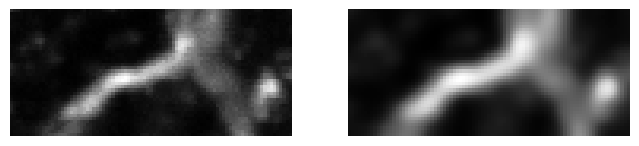

In [10]:
## Motion Correction setup
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
reference_num = np.int_(np.round(0.1 * volume_cycle))
refImg = np.mean(stackMP[0:reference_num,:,:],axis=0)

from scipy.ndimage import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

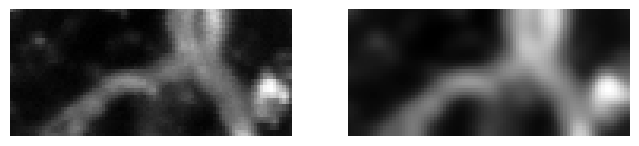

In [11]:
if red == 1:
    ## Motion Correction setup
    # Set reference image
    stackMP_red = np.max(imgStack_red, axis=1) # max projection over volume
    # Generate reference image
    reference_num = np.int_(np.round(0.1 * volume_cycle))
    refImg_red = np.mean(stackMP_red[0:reference_num,:,:],axis=0)

    from scipy.ndimage import gaussian_filter 
    refImgFilt_red = gaussian_filter(refImg_red, sigma=2)

    fig, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(refImg_red,cmap='Greys_r', origin='lower'); axs[0].axis('off');
    axs[1].imshow(refImgFilt_red,cmap='Greys_r', origin='lower'); axs[1].axis('off');

perform motion correction on a single plane/max projection


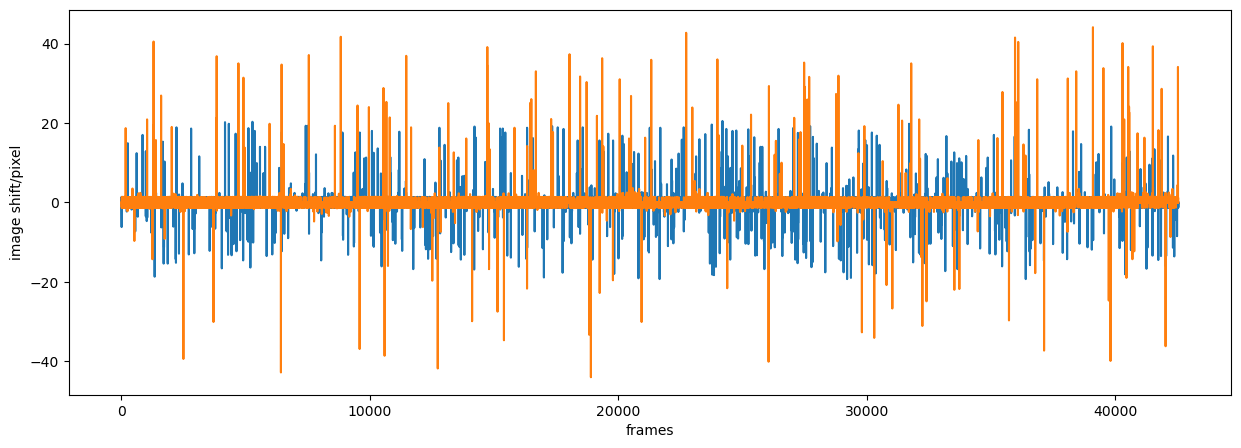

In [12]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

perform motion correction on a single plane/max projection


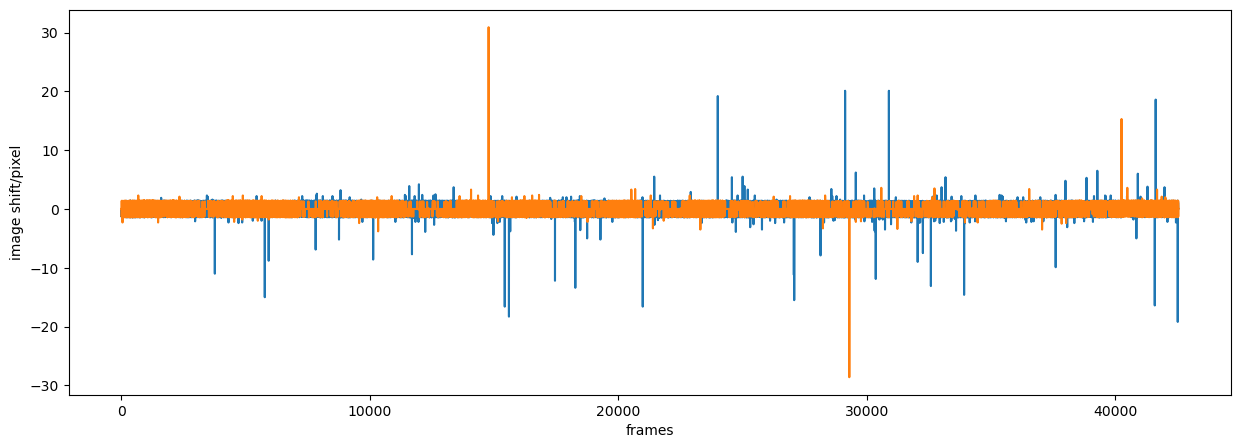

In [13]:
if red == 1:
    shift_red = computeMotionShift(stackMP_red, refImg_red, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [14]:
stack4dMC = motionCorrection(imgStack, shift)

In [15]:
if red == 1:
    stack4dMC_red = motionCorrection(imgStack_red, shift_red)

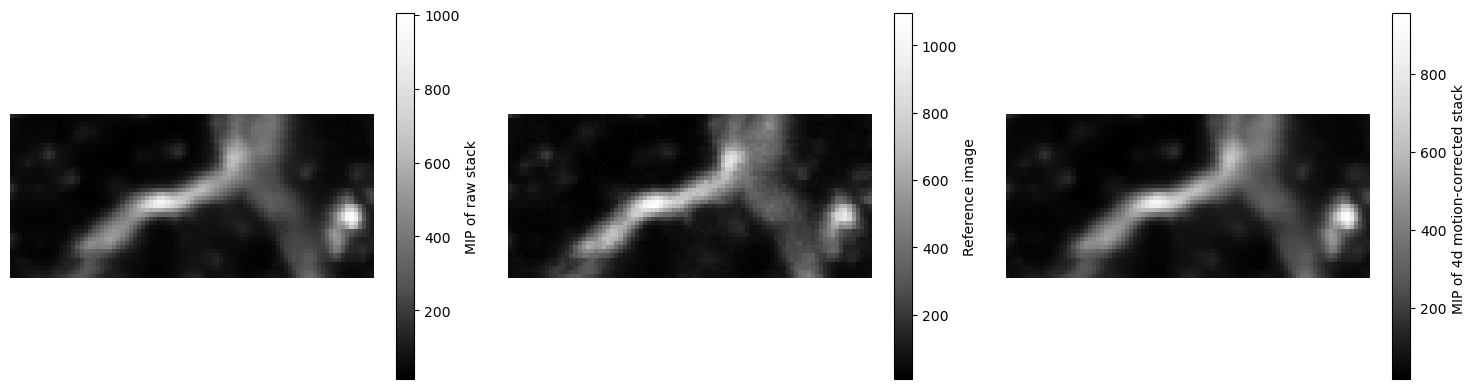

In [16]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [68]:
if red == 1:
    imgStack_napari_red = np.expand_dims(imgStack_red, axis =0)
if green == 1:
    #stack4dMCTEST = np.expand_dims(stack4dMC, axis =0)
    imgStack_napari = np.expand_dims(imgStack, axis =0)

In [69]:
# Use this for EB roi
if brain_region == 0:
    ebnapari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(stack4dMCTEST.mean(axis=1))
# Use this for PB roi
else:
    viewer = napari.Viewer()
    #new_layer = viewer.add_image(imgStack_napari_red.mean(axis=1)))
    new_layer = viewer.add_image(imgStack_napari)
    #viewer.dims.ndisplay = 3

In [15]:
if brain_region == 0:
    ebnapari.make_phase_masks()

In [70]:
label = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/napari_roi/delta7_ASAP5/napari_ROI_TQfly139/ROI_1_TQfly142_012_green.tif")
if red == 1:
    label_red = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/napari_roi/delta7_ASAP5/napari_ROI_TQfly139/ROI_1_TQfly142_012_red.tif")
#viewer.add_labels(label, name='Labels_16_Roi'

In [71]:
#Load ROI and label from napari
#napari_roi_16 = viewer.layers['Labels_16_Roi'].data
if brain_region == 0: 
    napari_roi = label    
else:
    #napari_roi = label[0,:,:,:]
    #Start from TQfly081, easier way to save ROI
    napari_roi = np.squeeze(label , axis=0) 
    if red == 1:
        napari_roi_red = np.squeeze(label_red , axis=0) 

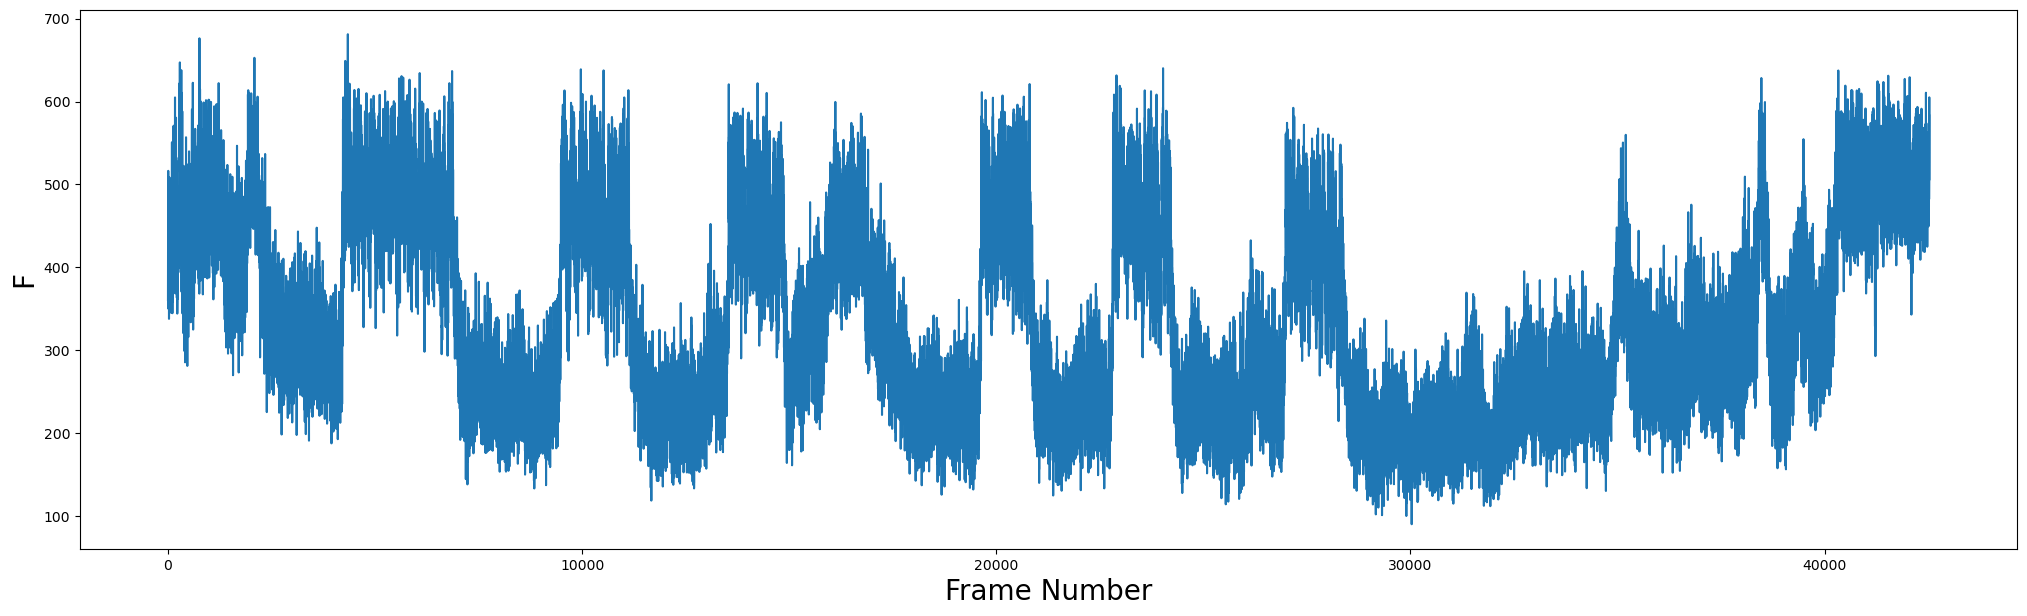

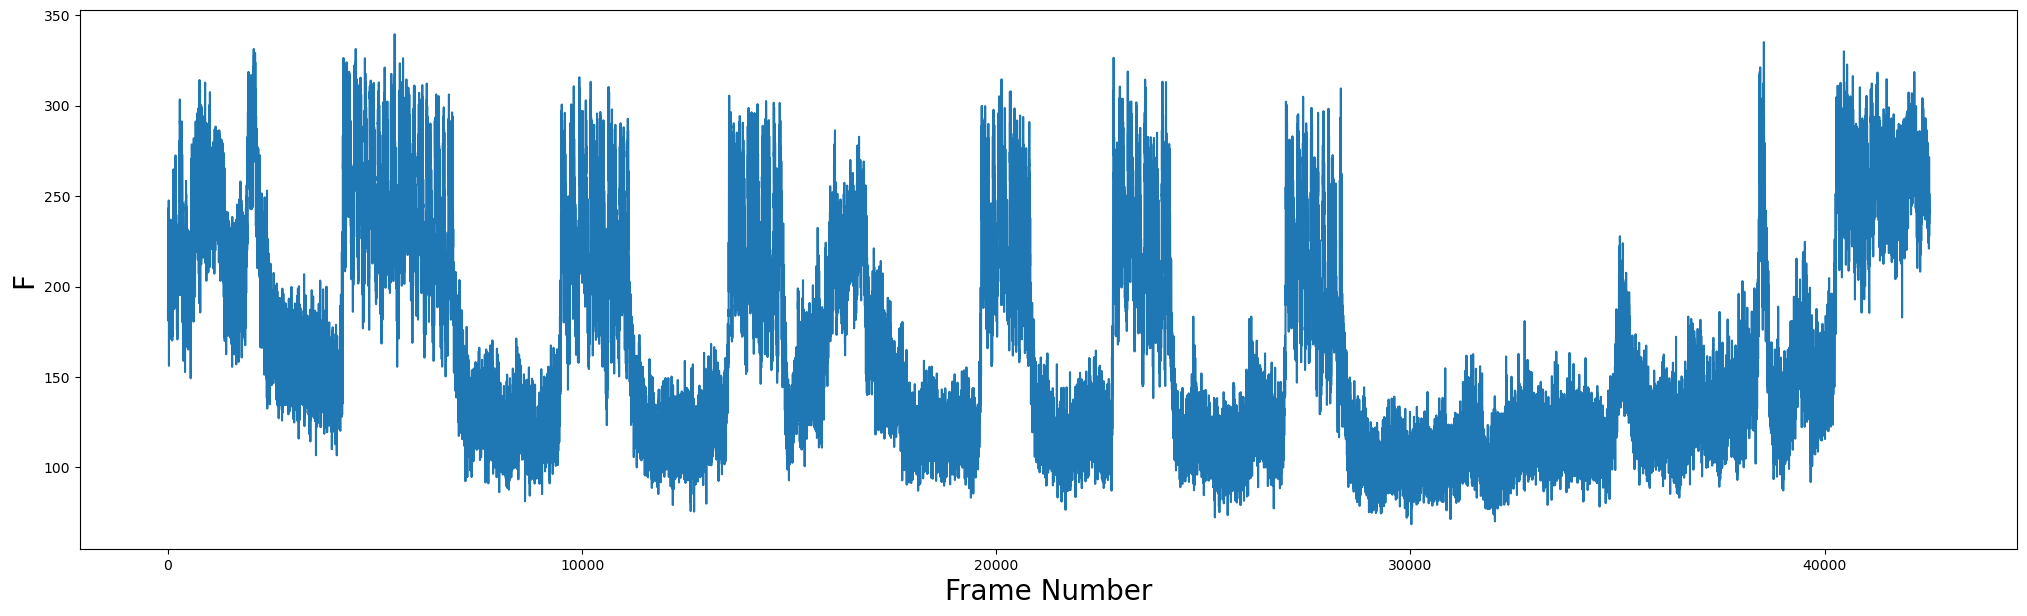

In [72]:
ROI_total = 1
F_array = get_raw_F(ROI_total, napari_roi, imgStack)
if red == 1:
    F_array_red = get_raw_F(ROI_total, napari_roi_red, imgStack_red)

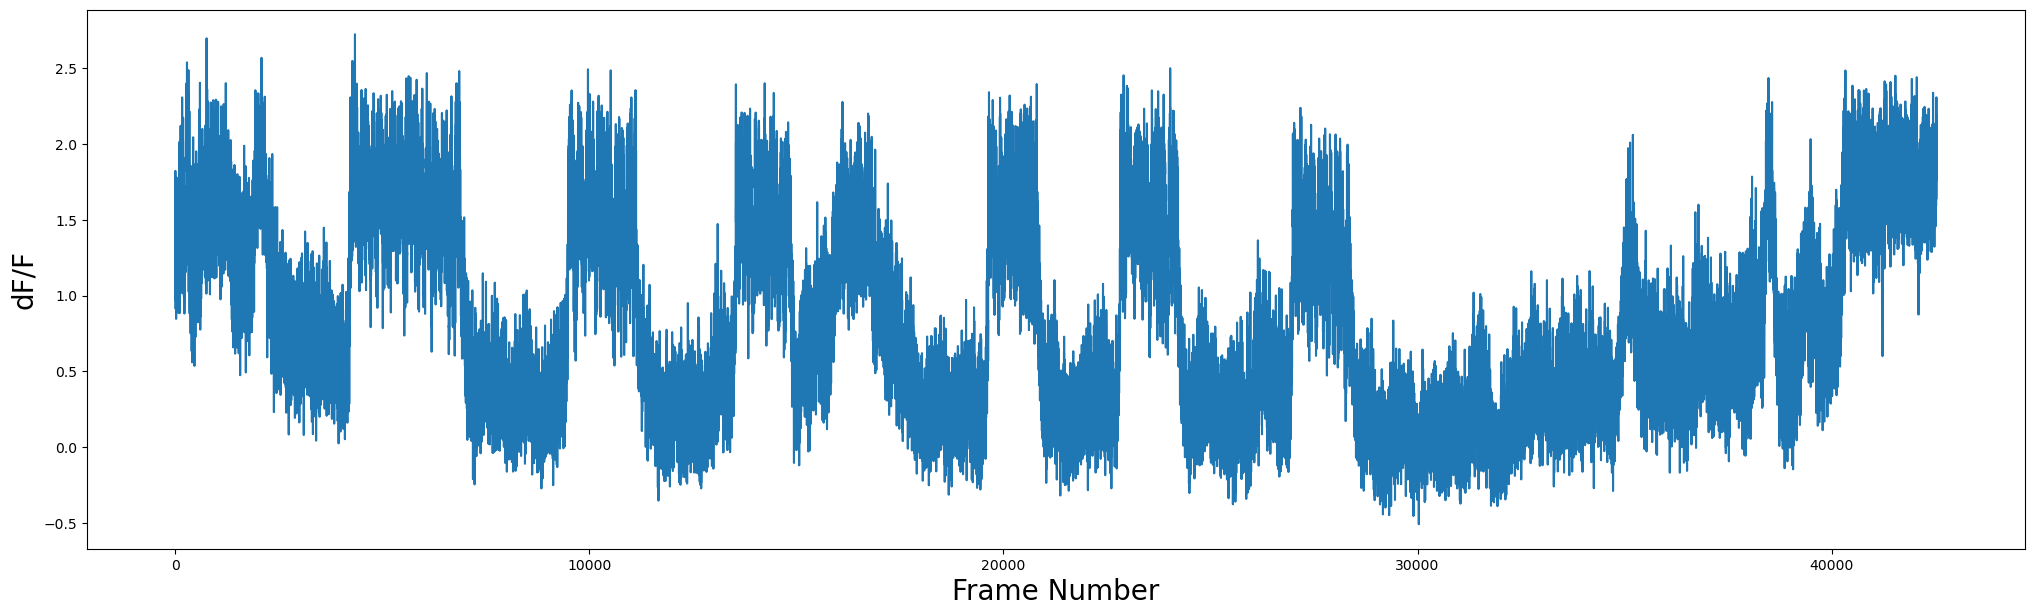

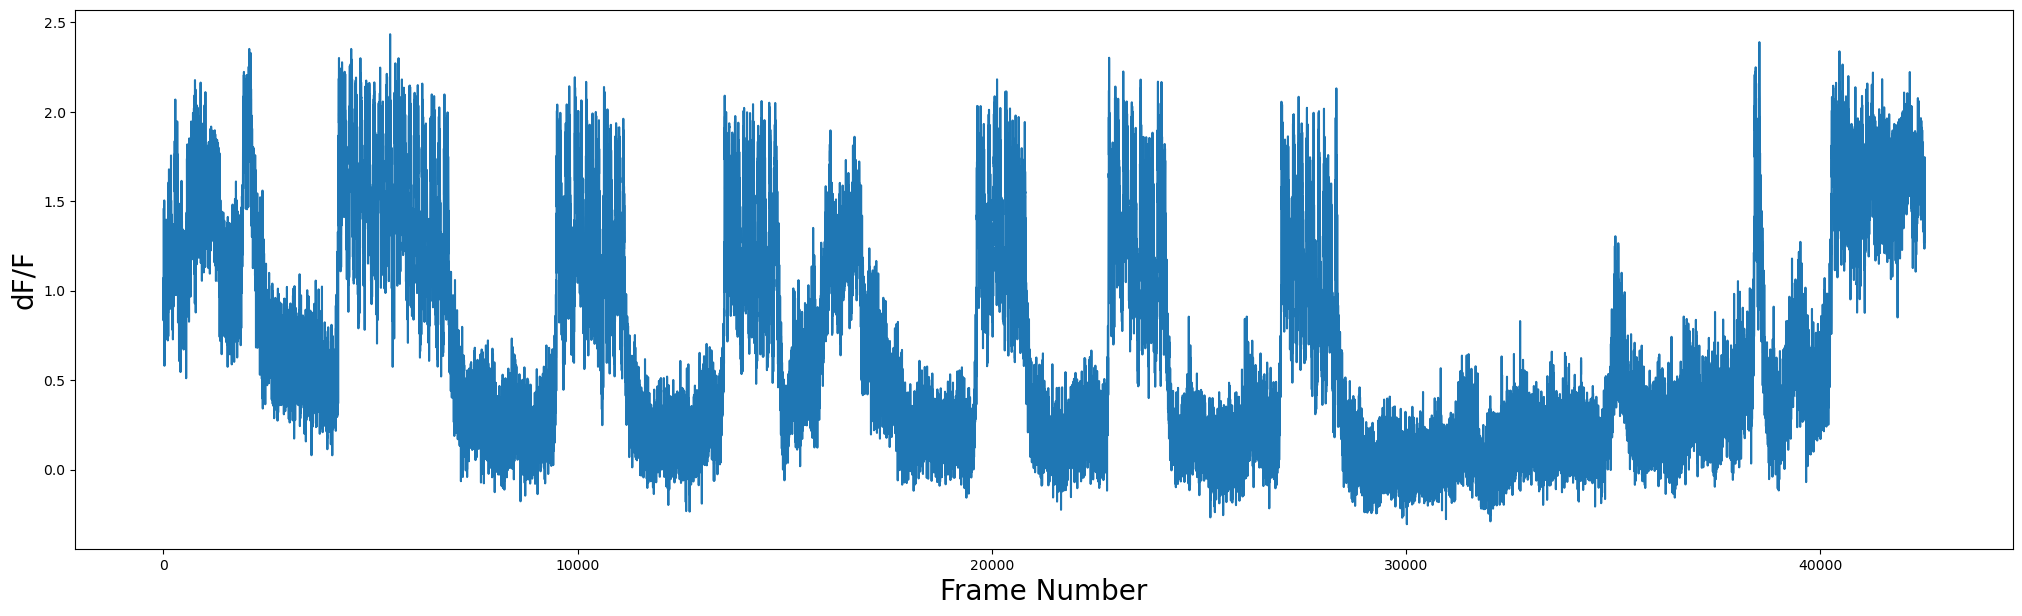

In [73]:
dF_F_array = get_dff_array(raw_F_array = F_array, ROI_num = ROI_total, F_zero_cutoff = 0.05)
if red == 1:
    dF_F_array_red = get_dff_array(raw_F_array = F_array_red, ROI_num = ROI_total, F_zero_cutoff = 0.05)

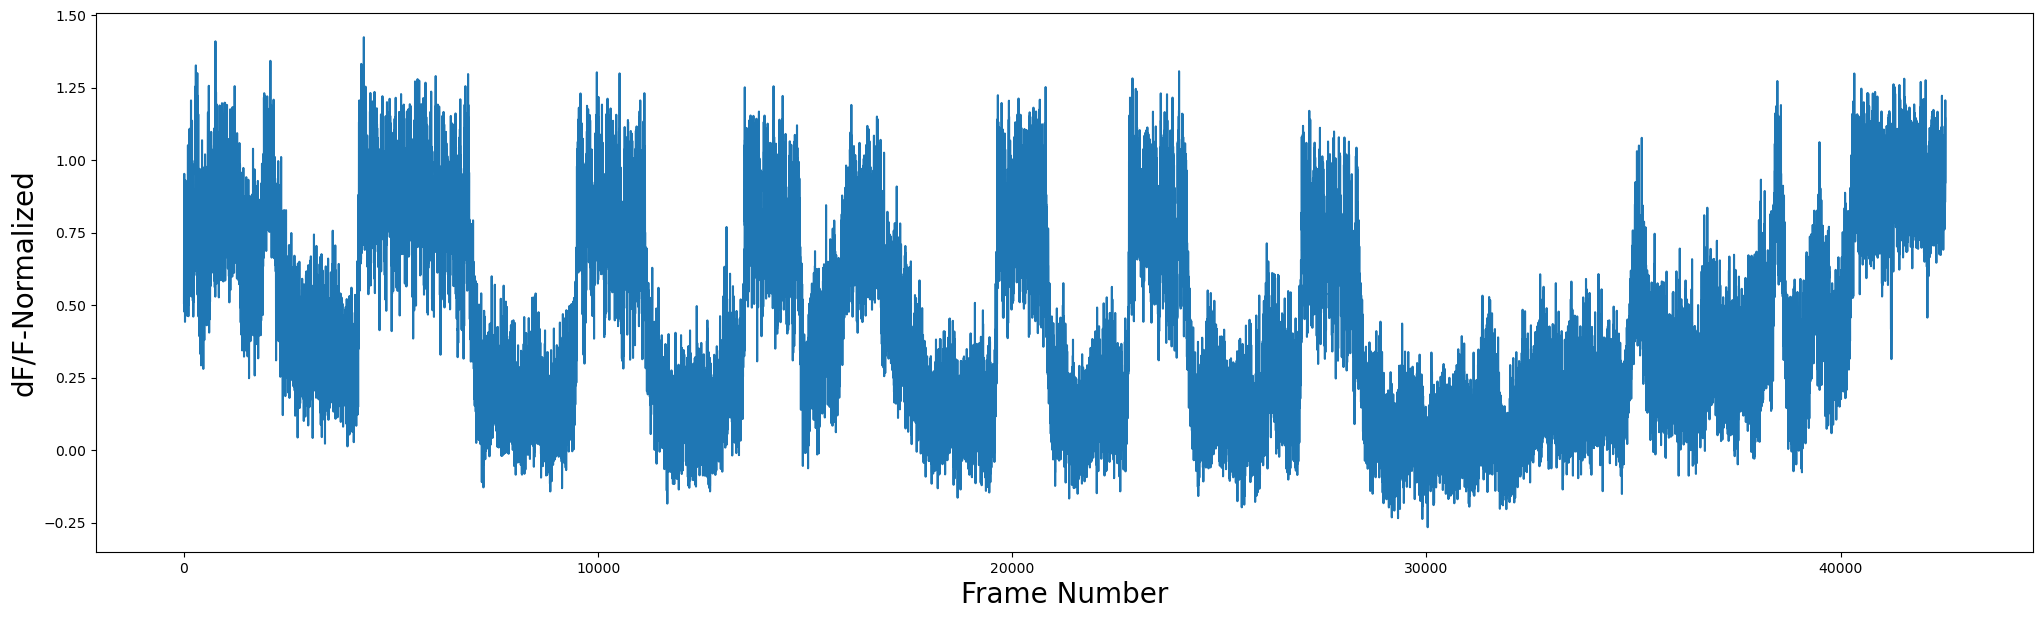

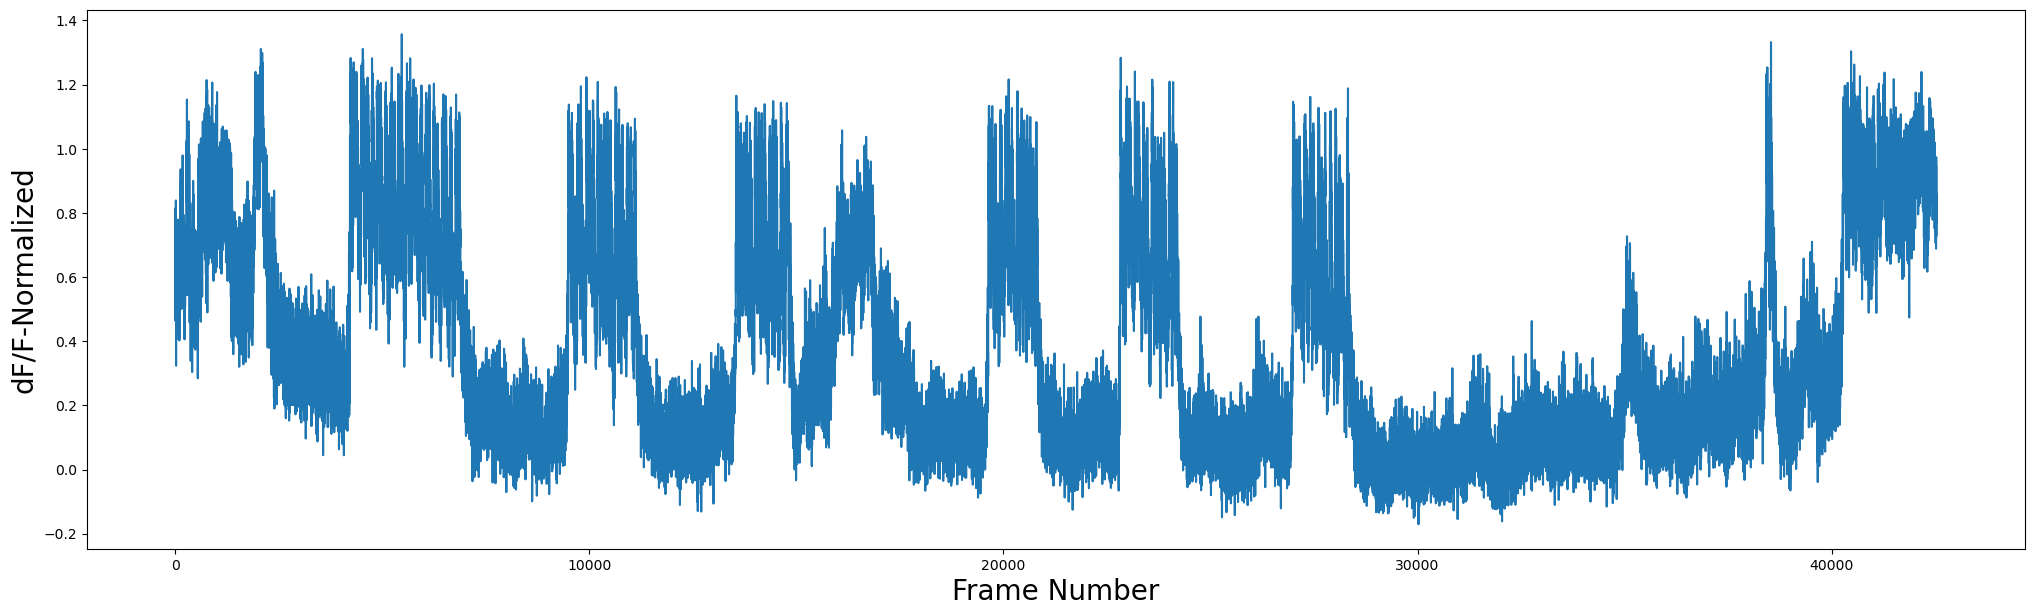

In [74]:
dF_F_array_normalized = normalizing_dff_array(dF_F_array,ROI_num= ROI_total, normalize_cutoff= 0.95)
if red == 1:
    dF_F_array_normalized_red = normalizing_dff_array(dF_F_array_red,ROI_num= ROI_total, normalize_cutoff= 0.95)

In [75]:
# Z-score: alternative way to calculate df/f
Z_score_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_total))
F_sd = np.std(F_array, axis = 0)
F_mean = np.mean(F_array, axis = 0)
for z_index in range(ROI_total):
    Z_score_array [:,z_index] = (F_array[:,z_index] - F_mean[z_index])/F_sd[z_index]

In [76]:
#Median_filtering the normalized df_f trace
for i in range (ROI_total):
    dF_F_array_normalized[:,i] = signal.medfilt(dF_F_array_normalized[:,i],kernel_size =3)
    Z_score_array [:,i] = signal.medfilt(Z_score_array [:,i],kernel_size =3)
    if red == 1:
        dF_F_array_normalized_red[:,i] = signal.medfilt(dF_F_array_normalized_red[:,i],kernel_size =3)
    

In [28]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Desktop/TQfly142-012/TQfly142-012_Cycle00001_VoltageRecording_001.csv')

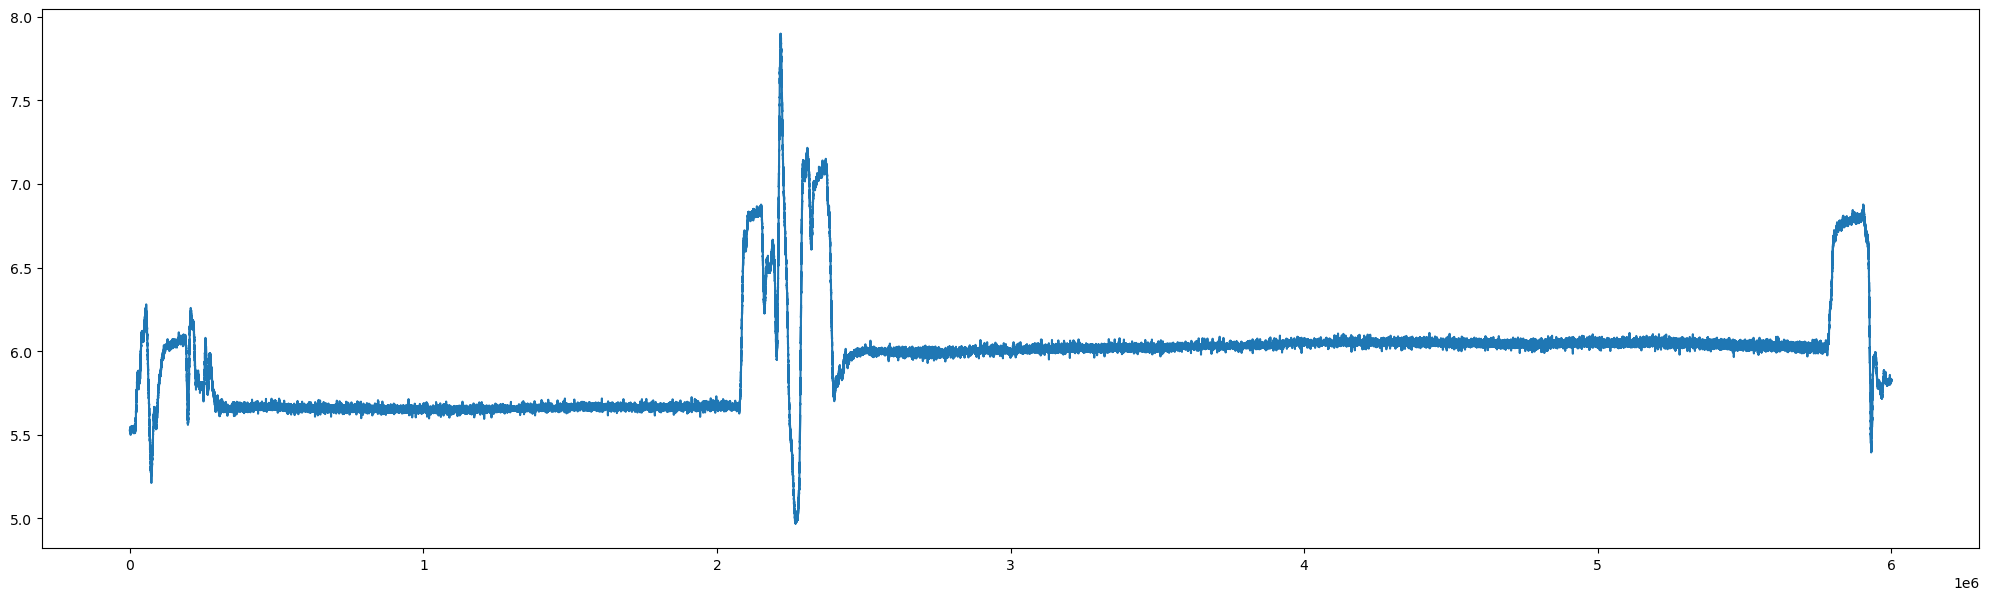

In [29]:
#Input4 = Heading, Input6 =x , Input7 =y
voltage_recording_heading = voltage_recording[' Heading']
plt.figure(figsize= (25,7))
plt.plot(voltage_recording[' Heading'])

In [30]:
#Read the fictrac raw .dat file and trial start/end info from Bruker
fictrac_data = pd.read_table('/home/tianhaoqiu/Desktop/Fictrac/TQfly142-09302023/fictrac-20230930_131821.dat', sep =',', header = None, names = ['frame counter', 'delta rotation vector x (cam)', 'delta rotation vector y (cam)','delta rotation vector z (cam)','delta rotation over score', 'delta rotaion vector 1 (lab)','delta rotaion vector 2 (lab)', 'delta rotaion vector 3 (lab)', 'absolute rotation vector 1 (cam)','absolute rotation vector 2 (cam)','absolute rotation vector 3 (cam)','absolute rotation vector 1 (lab)','absolute rotation vector 2 (lab)','absolute rotation vector 3 (lab)','integrated x', 'integrated y','integrated heading','animal movement direcrtion','animal movement speed', 'integrated forward motion','integrated side motion','timestamp','sequence counter','delta timestamp','alt.timestamp'] )
fictrac_data

frame counter  delta rotation vector x (cam)   
0                    0                       0.000000  \
1                    1                      -0.000580   
2                    2                       0.000059   
3                    3                       0.001503   
4                    4                       0.001353   
...                ...                            ...   
3283768        3285082                       0.001040   
3283769        3285083                       0.000063   
3283770        3285084                      -0.004234   
3283771        3285085                       0.004752   
3283772        3285086                      -0.002711   

         delta rotation vector y (cam)  delta rotation vector z (cam)   
0                             0.000000                       0.000000  \
1                             0.000163                       0.000304   
2                            -0.000029                      -0.000257   
3                            -0.000190                      -0.001688   
4                            -0.000172                      -0.001539   
...                                ...                            ...   
3283768                       0.001086                       0.003368   
3283769                      -0.000200                       0.007416   
3283770                      -0.000571                      -0.013355   
3283771                      -0.005293                       0.000547   
3283772                       0.000703                      -0.004047   

         delta rotation over score  delta rotaion vector 1 (lab)   
0                         0.000000                      0.000000  \
1                      4186.302534                      0.000587   
2                      3961.857778                     -0.000248   
3                      3943.658462                     -0.002247   
4                      3732.641975                     -0.002040   
...                            ...                           ...   
3283768                4514.290990                      0.002294   
3283769                3841.949778                      0.006085   
3283770                3745.901034                     -0.008740   
3283771                4226.144756                     -0.002607   
3283772                3649.852290                     -0.001786   

         delta rotaion vector 2 (lab)  delta rotaion vector 3 (lab)   
0                            0.000000                      0.000000  \
1                           -0.000307                      0.000128   
2                           -0.000094                     -0.000006   
3                            0.000305                     -0.000024   
4                            0.000264                     -0.000021   
...                               ...                           ...   
3283768                      0.002773                      0.000808   
3283769                      0.004162                     -0.000834   
3283770                     -0.010952                      0.000518   
3283771                      0.004061                     -0.005254   
3283772                     -0.004474                      0.001010   

         absolute rotation vector 1 (cam)  absolute rotation vector 2 (cam)   
0                                0.000000                          0.000000  \
1                               -0.000580                          0.000163   
2                               -0.000521                          0.000133   
3                                0.000983                         -0.000056   
4                                0.002336                         -0.000228   
...                                   ...                               ...   
3283768                         -0.842709                          0.914566   
3283769                         -0.846029                          0.911249   
3283770                         -0.843815                         

In [31]:
with open('/home/tianhaoqiu/Desktop/Fictrac/TQfly142-09302023/TQfly142_scan11.pkl', 'rb') as f:
    fictracinfo = pickle.load(f)
fictracinfo

{'start': [3194775],
 'opto': [],
 'abort': [3253519],
 'start_trig_falling_edge': [3194780]}

In [32]:
start_frame_index = fictracinfo['start_trig_falling_edge'][0] - 1
abort_frame_index = fictracinfo['abort'][0]

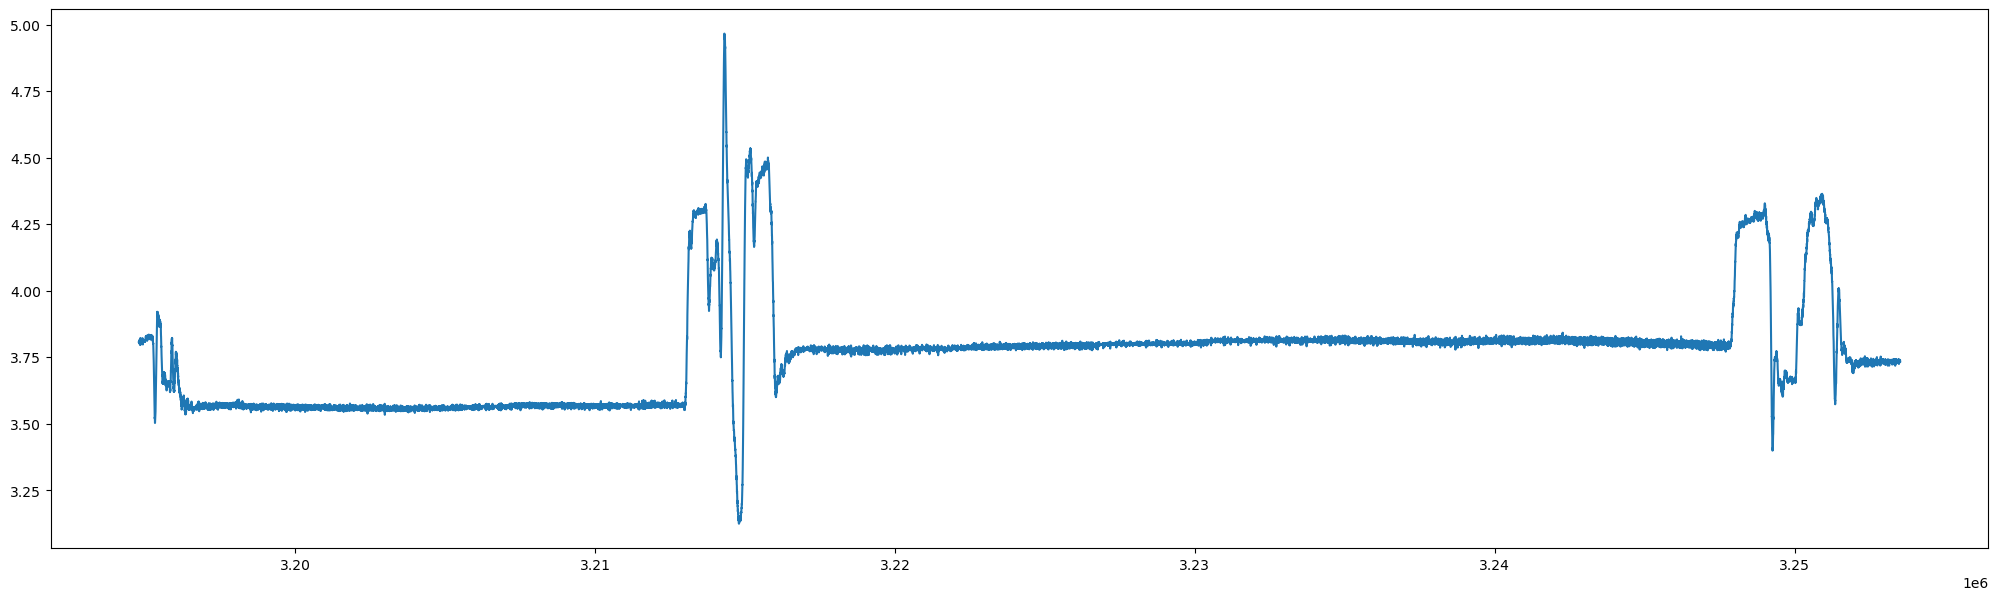

In [33]:
# the scanning start actually one frame before the falling_edge
fictrac_heading = fictrac_data['integrated heading']
fictrac_integrated_x = fictrac_data['integrated x']
fictrac_integrated_y = fictrac_data['integrated y']
plt.figure(figsize= (25,7))
plt.plot(fictrac_heading[start_frame_index:abort_frame_index ])

In [34]:
#change it to binary
fictrac_frame_proc = voltage_recording[' FicTrac Frame Proc.']
pinn_signal = np.zeros(len(fictrac_frame_proc))
for i in range(len(fictrac_frame_proc)):
    if fictrac_frame_proc[i] < 1:
        pinn_signal[i] = 0
    else:
        pinn_signal[i] = 1

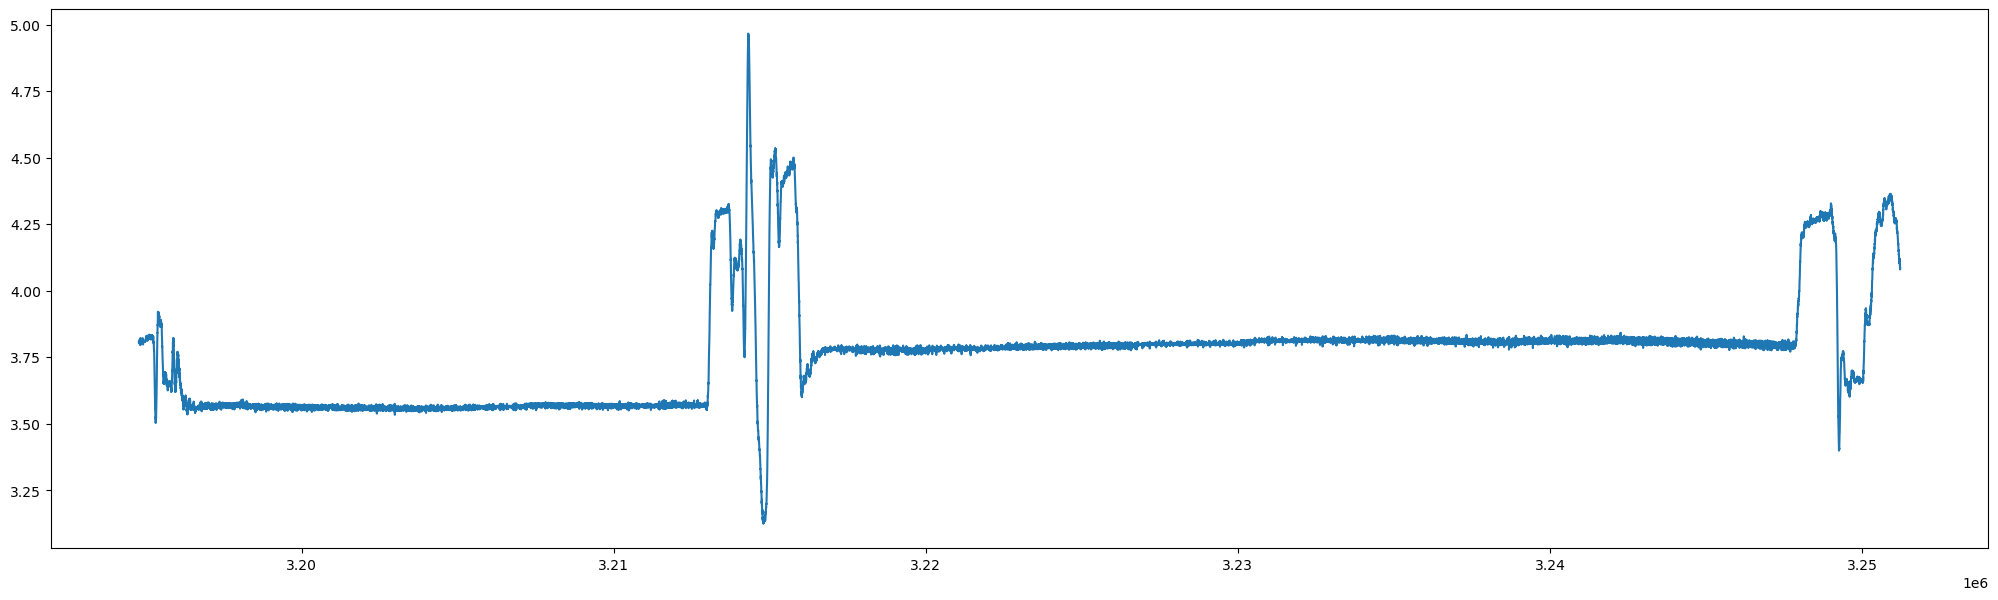

In [35]:
#find every time pinn value is up to 1(locked to each scanning frame)
up_index = np.argwhere(np.diff(pinn_signal)==1)
plt.figure(figsize= (25,7))
plt.plot(fictrac_heading[start_frame_index:start_frame_index+len(up_index)])
#fictrac_heading[start_frame_index:start_frame_index+len(up_index)].shape
plt.show()

In [36]:
behavior_sampling_rate =int(np.ceil(len(up_index)/(volume_cycle*volume_time)))

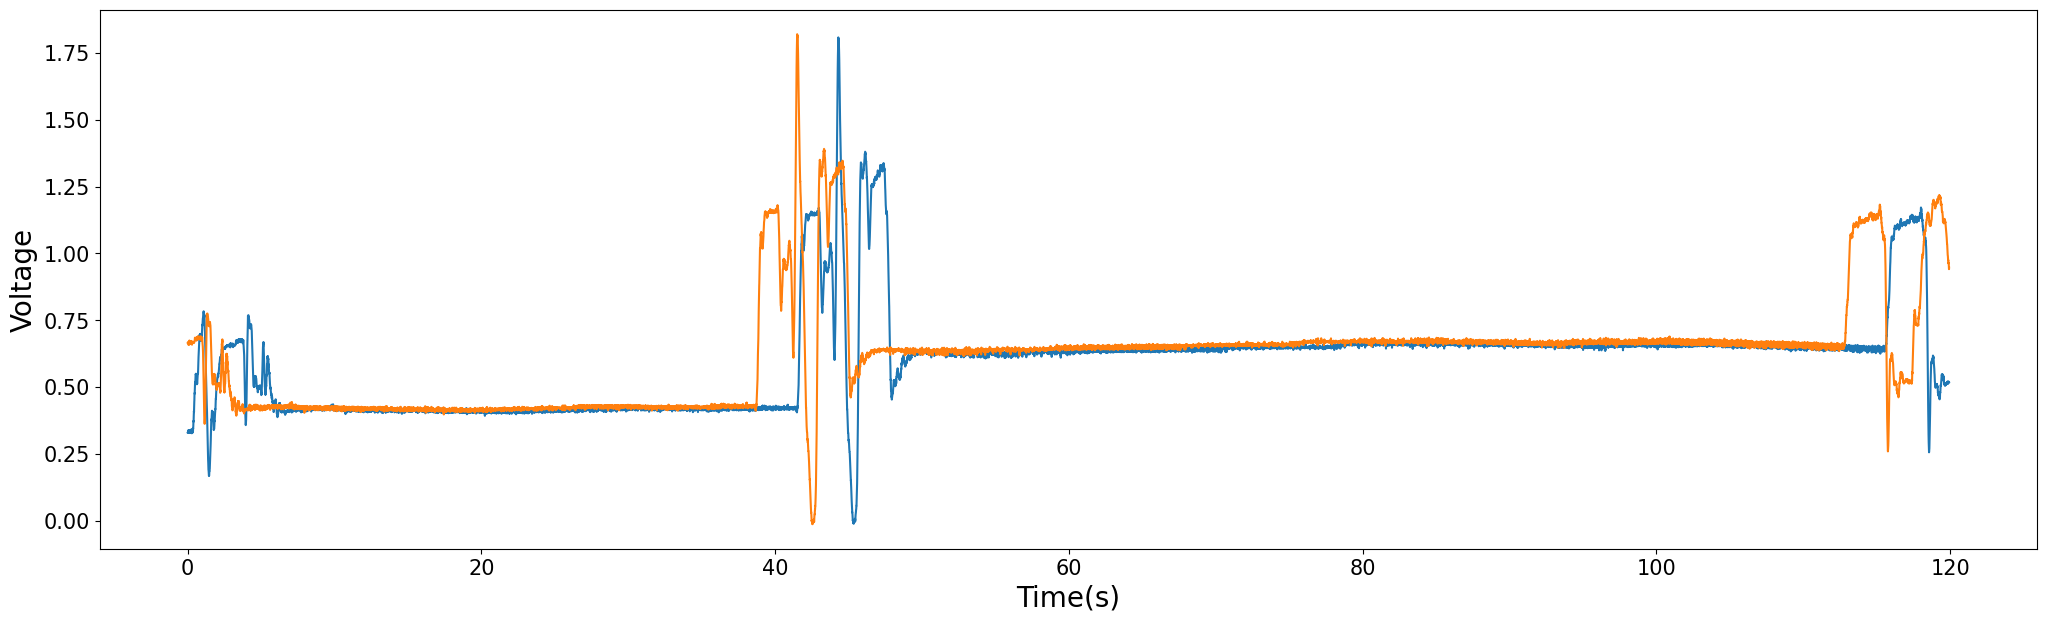

In [37]:
heading_array = voltage_recording [' Heading']
time_array_initial_fictrac = np.arange(len(heading_array))/fictrack_sampling_rate
head_array_filtered = low_pass_filter_TQ(heading_array, 100 ,fictrack_sampling_rate)
head_array_filtered = low_pass_filter_TQ(head_array_filtered, 100 ,fictrack_sampling_rate)
head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, head_array_filtered)

test = fictrac_heading[start_frame_index:start_frame_index+len(up_index)]
test_filtered = low_pass_filter_TQ(test, 100 ,behavior_sampling_rate)
test_filtered = low_pass_filter_TQ(test_filtered, 100 ,behavior_sampling_rate)
test_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, test_filtered)

plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled*np.pi*2/10-np.pi)
plt.plot(time_array_imaging,test_filtered_downsampled-np.pi)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)
plt.show()

In [38]:
import statsmodels.api as sm
correlate_array_fictrac_voltageRecording= np.zeros(10000)
for i in range(len(correlate_array_fictrac_voltageRecording)):
    test_fictrac_behavior = fictrac_heading[start_frame_index-i:start_frame_index-i+len(up_index)]
    test_fictrac_behavior = low_pass_filter_TQ(test_fictrac_behavior, 100 ,behavior_sampling_rate)
    test_fictrac_behavior= low_pass_filter_TQ(test_fictrac_behavior, 100 ,behavior_sampling_rate)
    test_fictrac_behavior = downsample_heading_to_total_volume(volume_cycle, test_fictrac_behavior)
    correlate_array_fictrac_voltageRecording[i] = np.correlate(test_fictrac_behavior-np.pi,head_array_downsampled*np.pi*2/10-np.pi)
np.argwhere(correlate_array_fictrac_voltageRecording==np.max(correlate_array_fictrac_voltageRecording))

array([[1318]])

In [39]:
corrected_frame =  np.argwhere(correlate_array_fictrac_voltageRecording==np.max(correlate_array_fictrac_voltageRecording))[0][0]
start_frame_index_corrected = start_frame_index - corrected_frame

In [40]:
corrected_frame 

1318

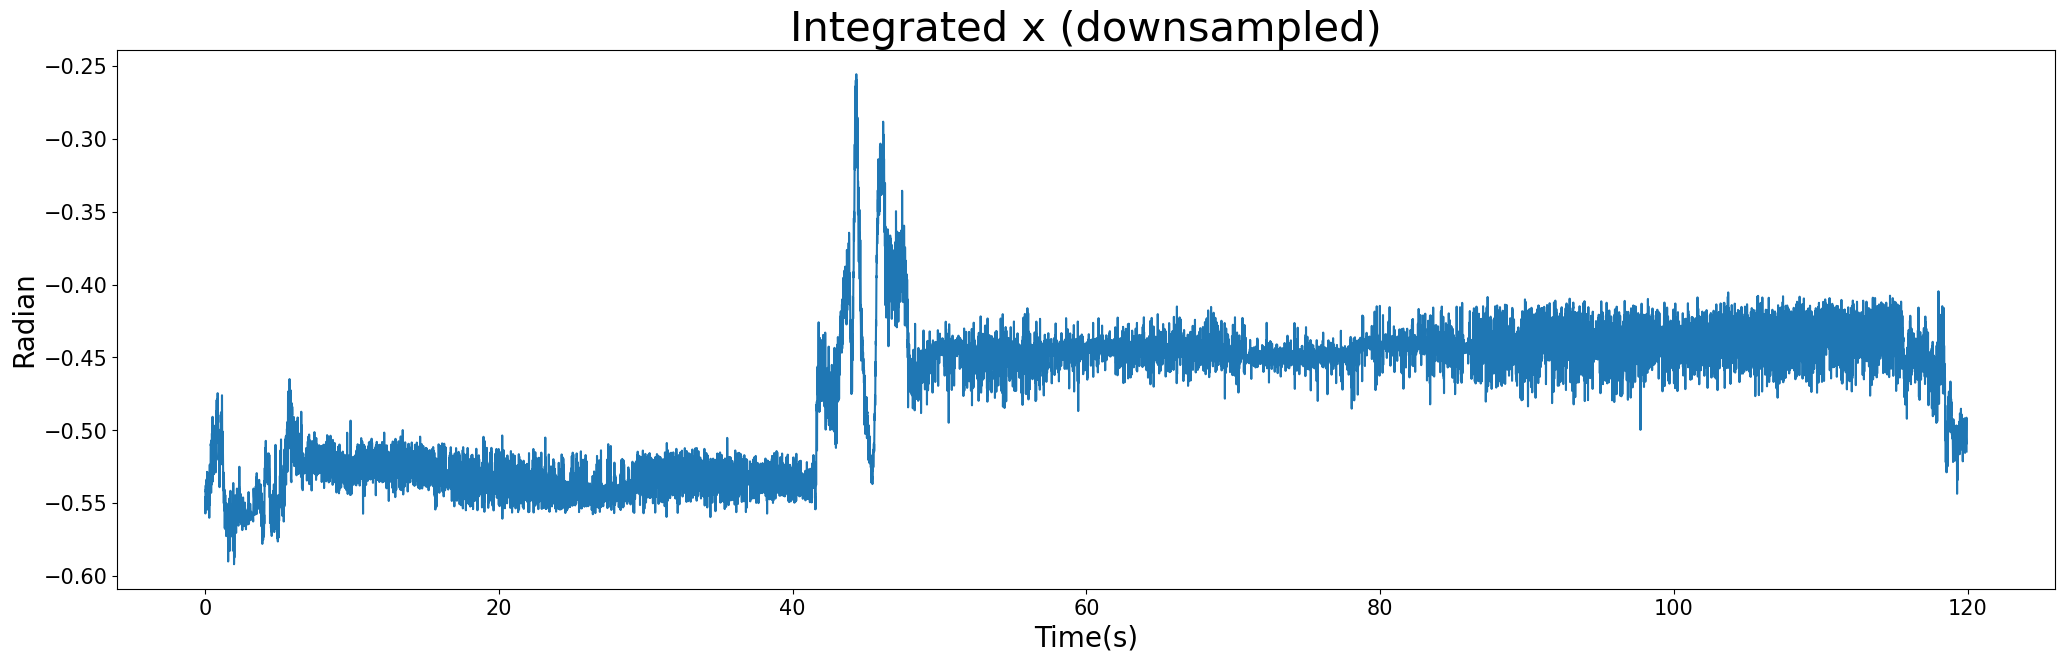

In [41]:
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x[start_frame_index_corrected :start_frame_index_corrected +len(up_index)],100,behavior_sampling_rate)
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x_filtered ,100,behavior_sampling_rate)
fictrac_integrated_x_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_x_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_x_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated x (downsampled)', fontsize =30)
plt.show()

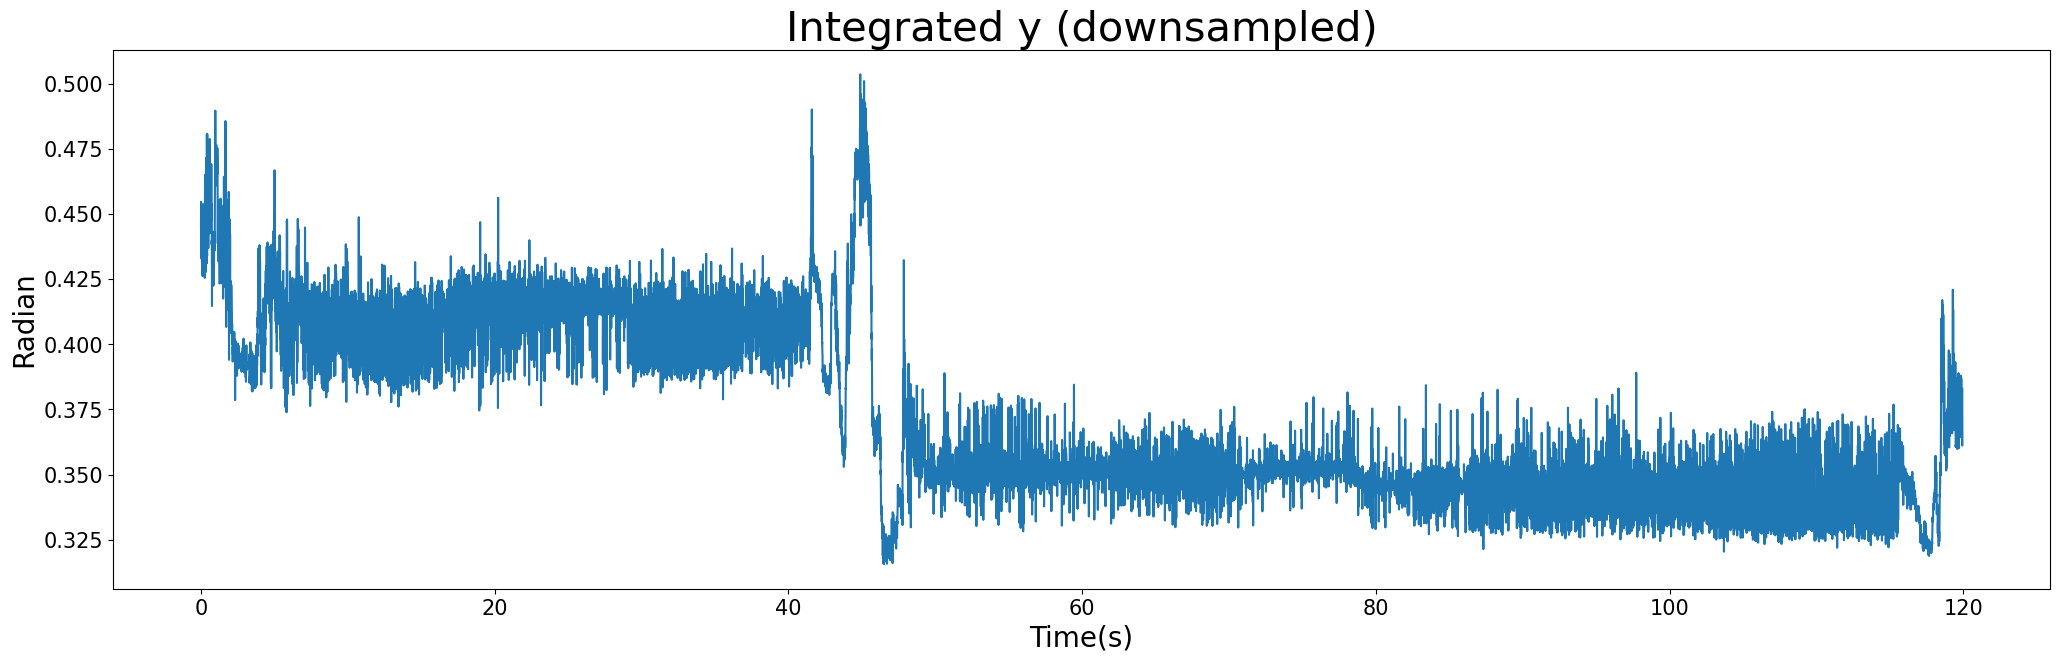

In [42]:
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y[start_frame_index_corrected :start_frame_index_corrected +len(up_index)],100,behavior_sampling_rate)
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y_filtered ,100,behavior_sampling_rate)
fictrac_integrated_y_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_y_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_y_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated y (downsampled)', fontsize =30)
plt.show()

In [43]:
fictrac_heading_corrected = fictrac_heading[start_frame_index_corrected :start_frame_index_corrected +len(up_index)]
fictrac_heading_corrected_filtered = low_pass_filter_TQ(fictrac_heading_corrected, 100 ,behavior_sampling_rate)
fictrac_heading_corrected_filtered = low_pass_filter_TQ(fictrac_heading_corrected_filtered, 100 ,behavior_sampling_rate)
fictrac_heading_corrected_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_heading_corrected_filtered)

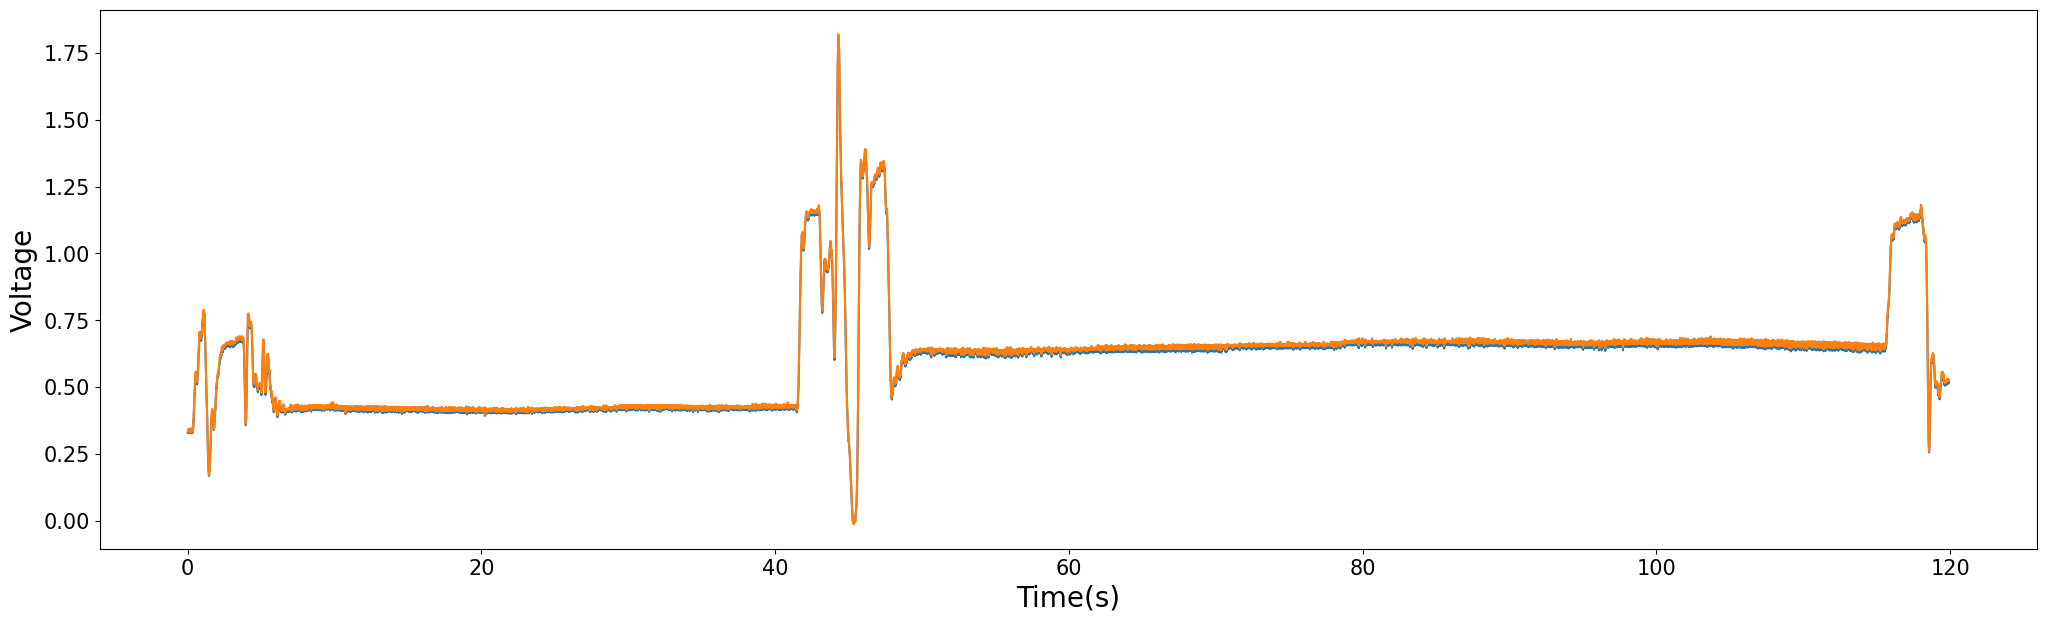

In [44]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled*np.pi*2/10-np.pi)
plt.plot(time_array_imaging,fictrac_heading_corrected_filtered_downsampled-np.pi)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)
plt.show()

In [45]:
#0-10V equivalent to -pi to pi
#head_array_downsampled_wrapped = head_array_downsampled * np.pi*2/10 - np.pi
head_array_downsampled_wrapped = fictrac_heading_corrected_filtered_downsampled -np.pi
barPosition_array_downsampled_wrapped = -head_array_downsampled_wrapped

In [46]:
max_Voltage = 10
heading_array_processed = fictrack_signal_decoding(barPosition_array_downsampled_wrapped, time_array_imaging, max_Voltage, already_radian = True)

In [47]:
heading_velocity = np.gradient(heading_array_processed)/volume_time
abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)
while (len(abnormal_velocity ) > 0):
    heading_velocity[abnormal_velocity ] = heading_velocity[abnormal_velocity -1]
    abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)

In [48]:
integrated_x_unwrapped =  fictrack_signal_decoding(fictrac_integrated_x_filtered_downsampled,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

In [77]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = heading_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))

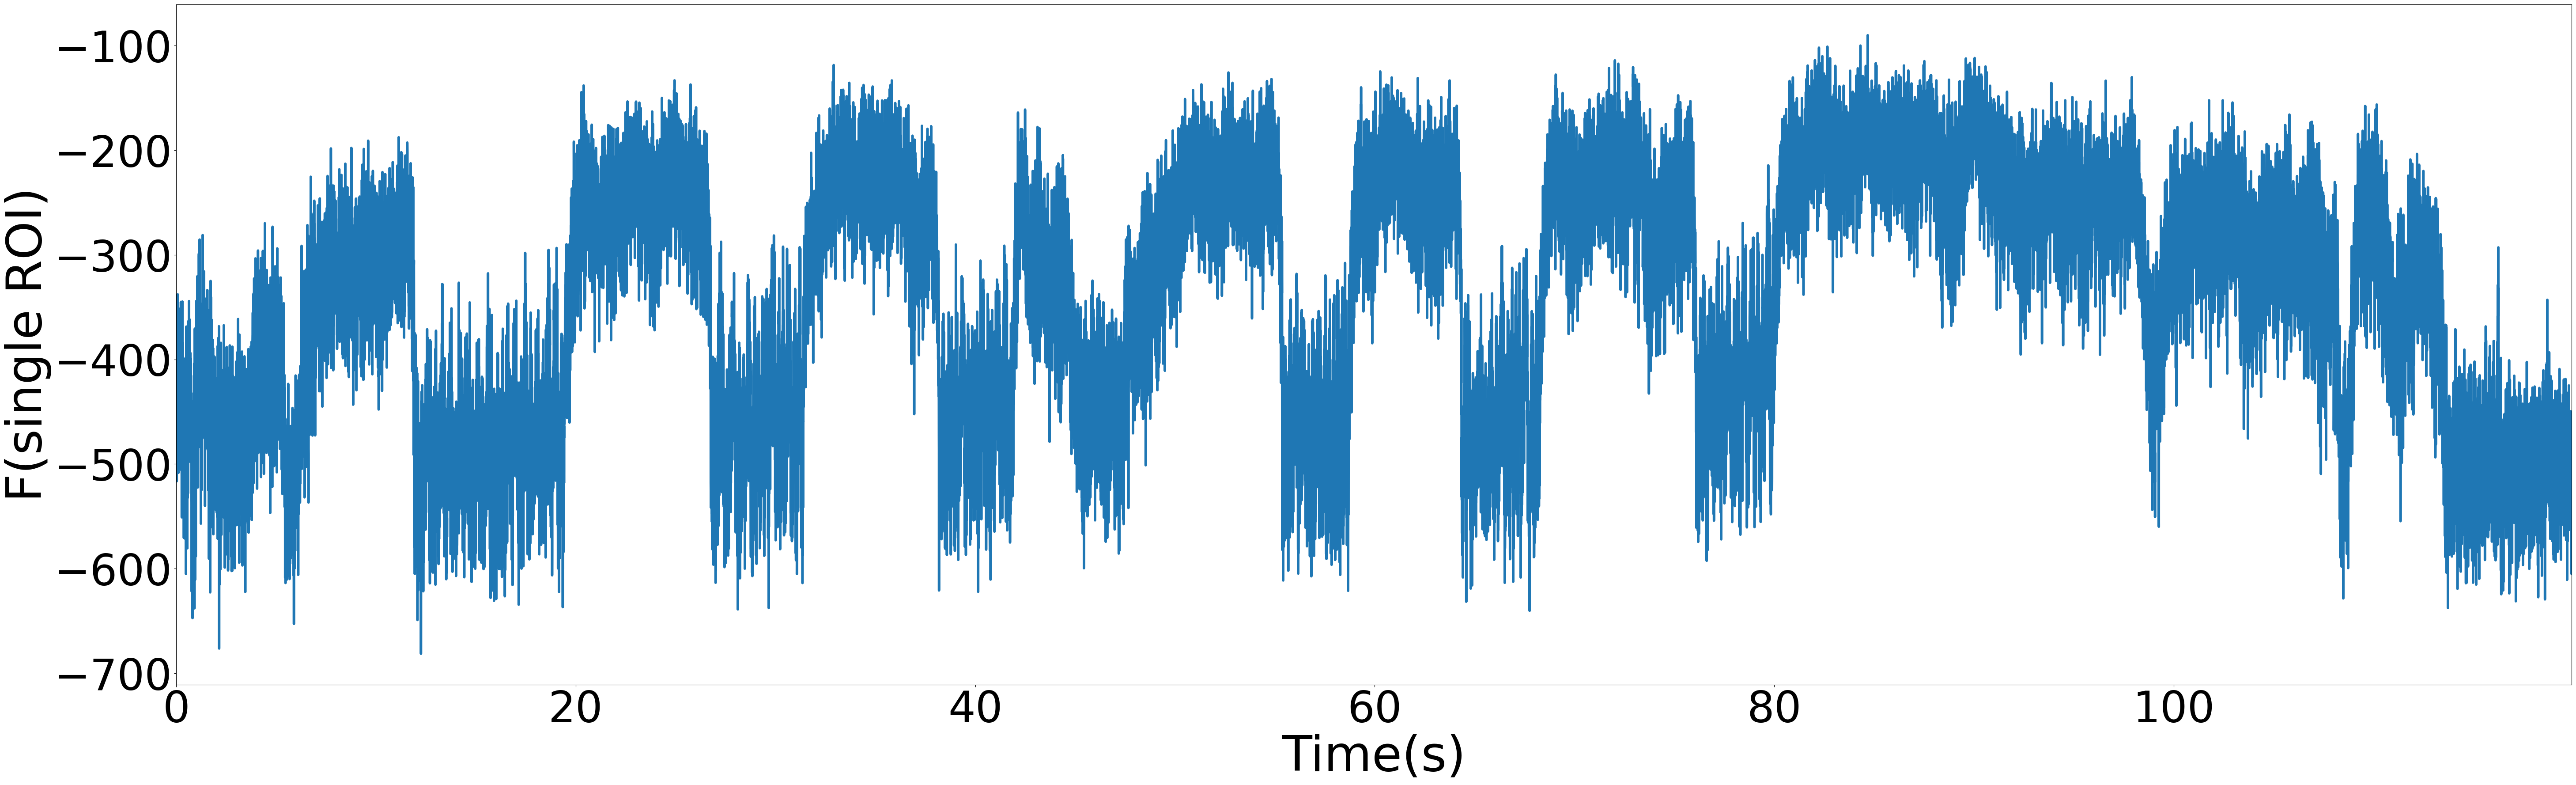

In [78]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,-F_array,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('F(single ROI)', fontsize=80)
plt.show()

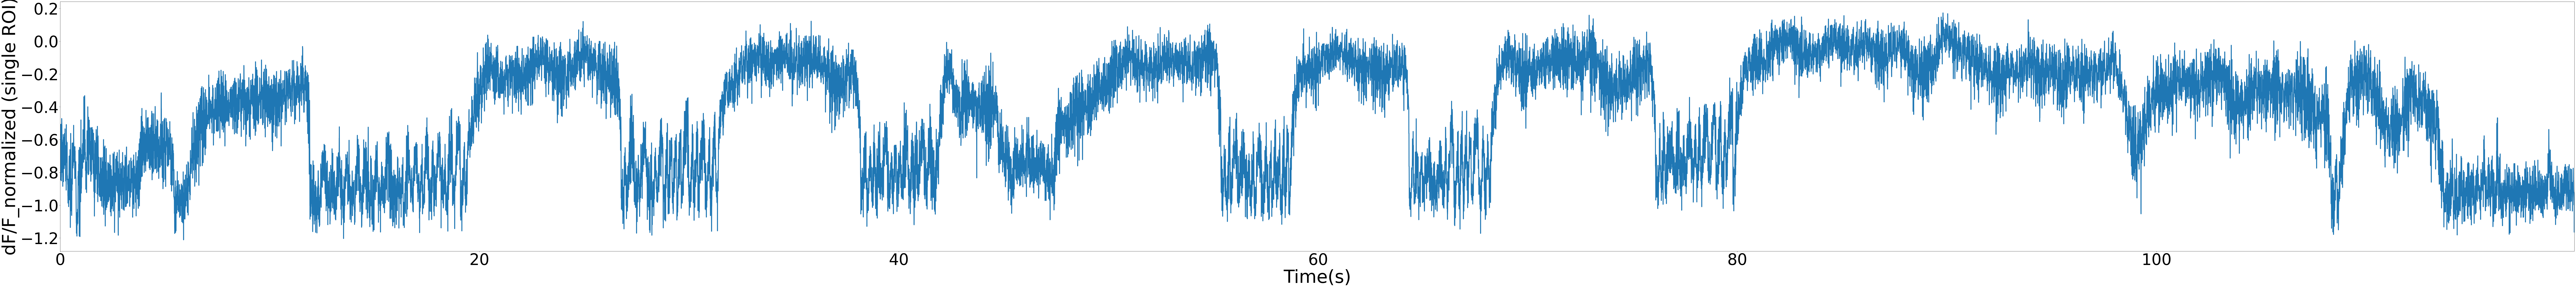

In [79]:
plt.figure(figsize= (200,20))
plt.plot(time_array_imaging,-dF_F_array_normalized,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('dF/F_normalized (single ROI)', fontsize=80)
plt.show()

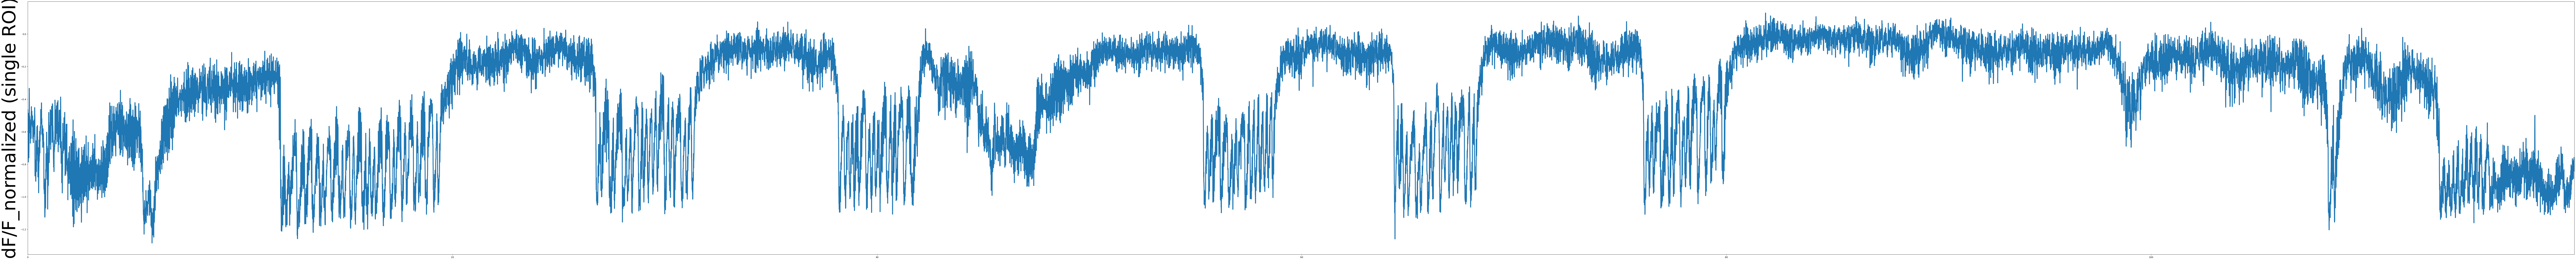

In [80]:
plt.figure(figsize= (200,20))
#plt.plot(time_array_imaging,-dF_F_array_normalized,linewidth =4)
plt.plot(time_array_imaging,-dF_F_array_normalized_red,linewidth =4)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('dF/F_normalized (single ROI)', fontsize=80)
plt.show()

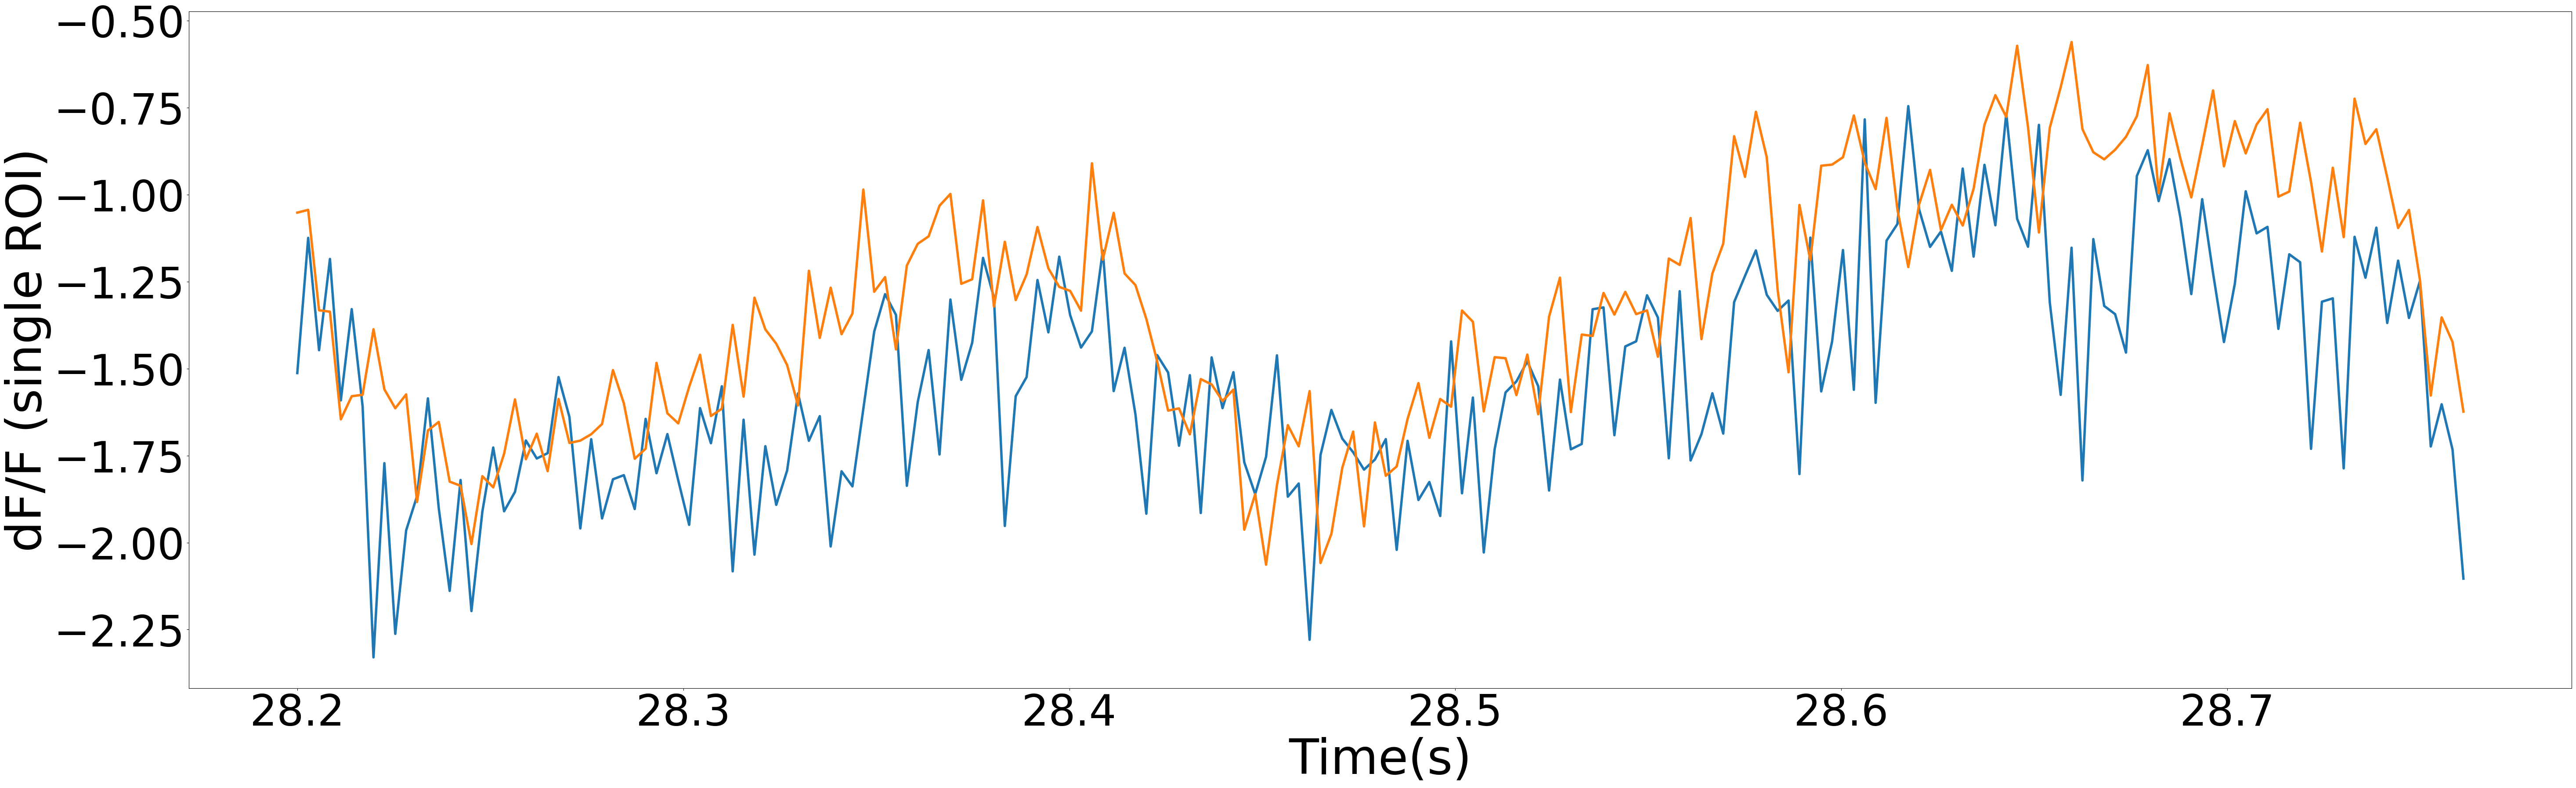

In [125]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging[10000:10200],-dF_F_array[10000:10200],linewidth =4)
plt.plot(time_array_imaging[10000:10200],-dF_F_array_red[10000:10200],linewidth =4)
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('dF/F (single ROI)', fontsize=80)
plt.show()

(array([-10000.,  -5000.,      0.,   5000.,  10000.,  15000.,  20000.]),
 [Text(0, -10000.0, '−10000'),
  Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000')])

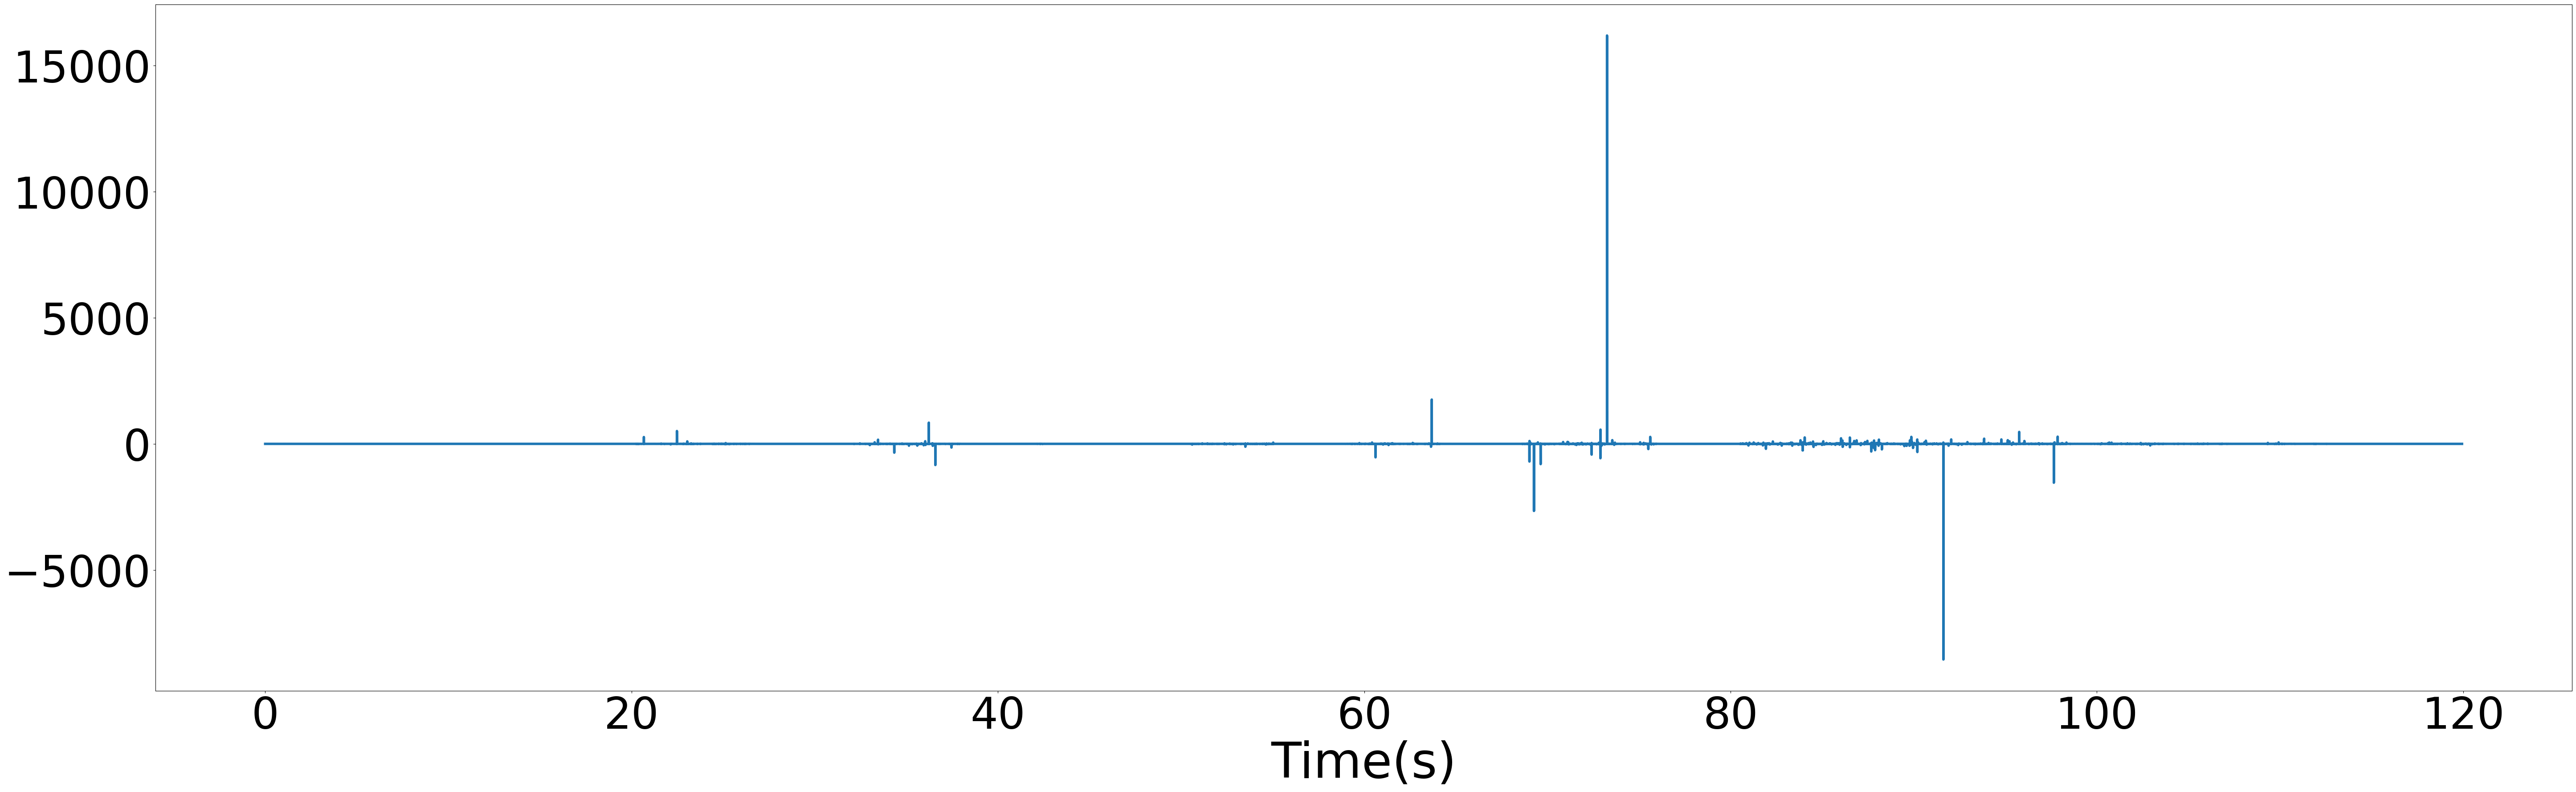

In [115]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,dF_F_array_normalized/dF_F_array_normalized_red,linewidth =4)
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

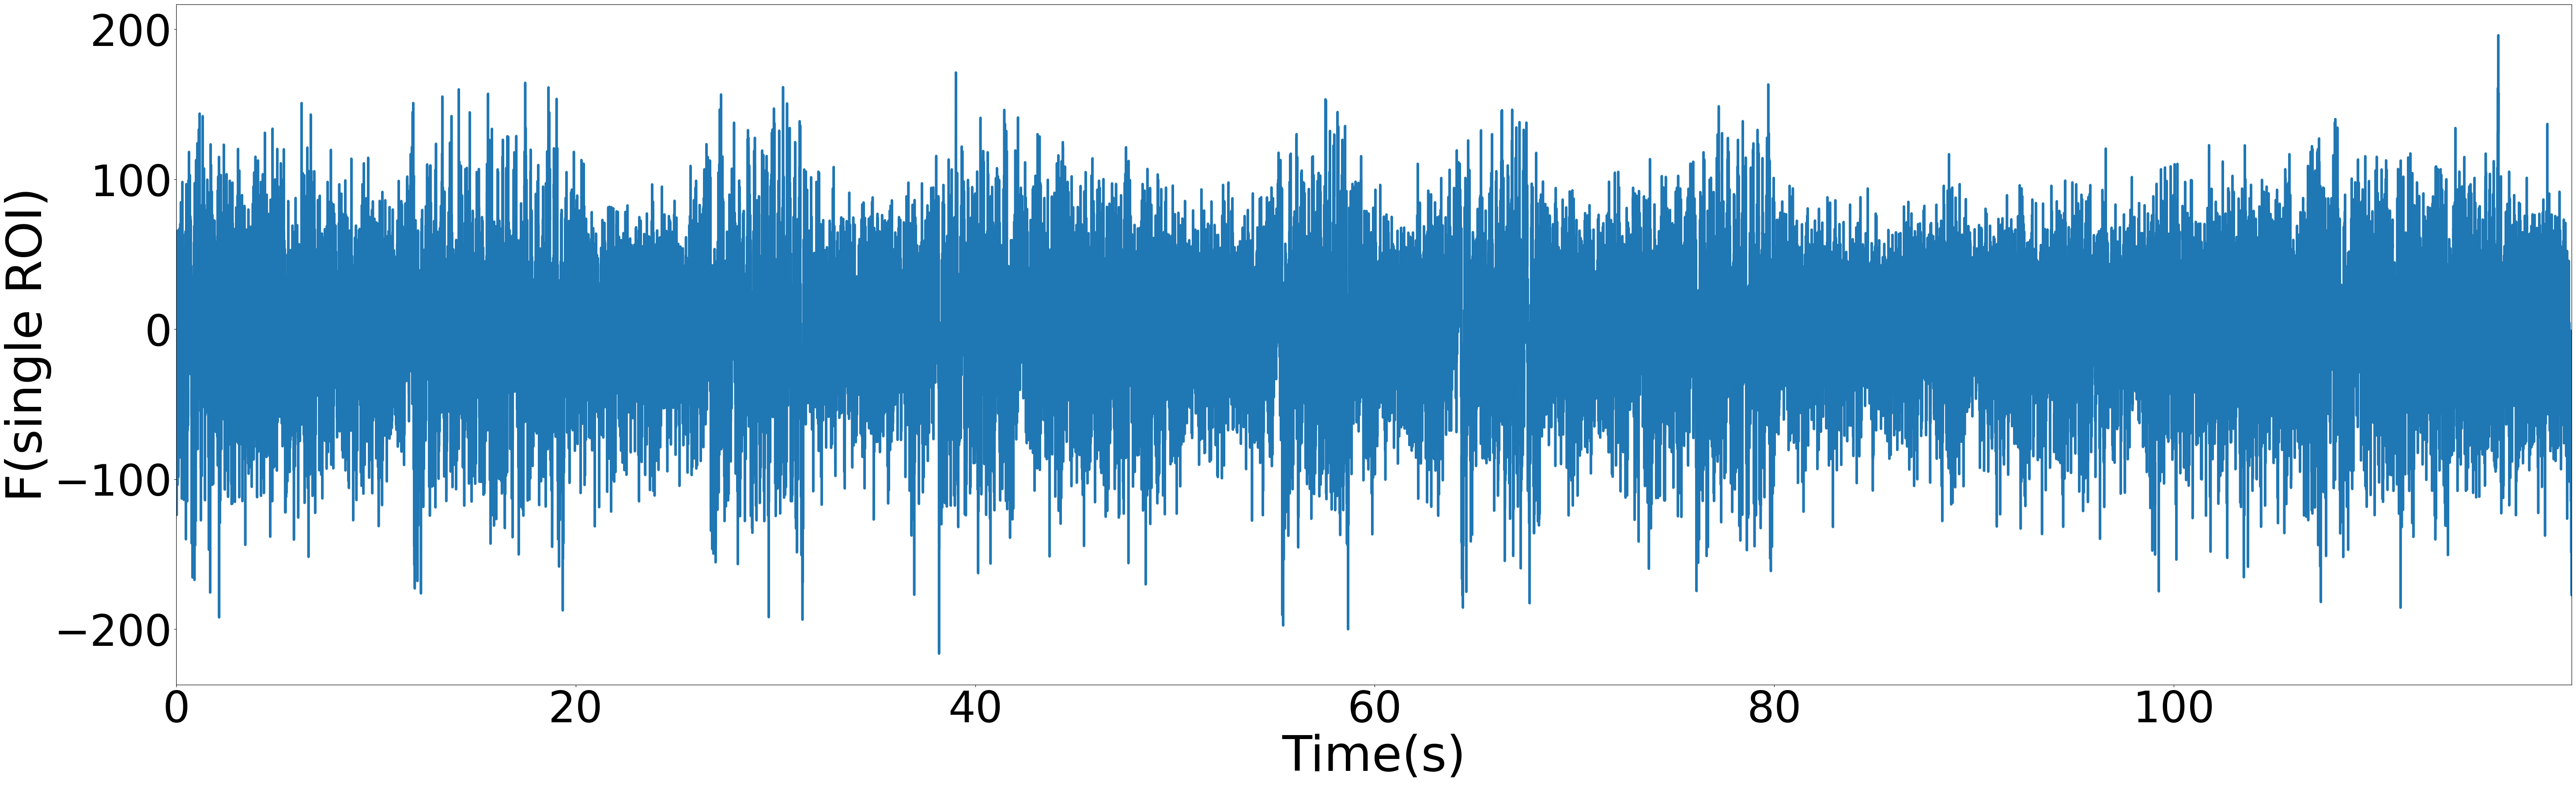

In [116]:
F_array_hp = high_pass_filter_TQ(F_array,1,volume_rate)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,-F_array_hp,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('F(single ROI)', fontsize=80)
plt.show()

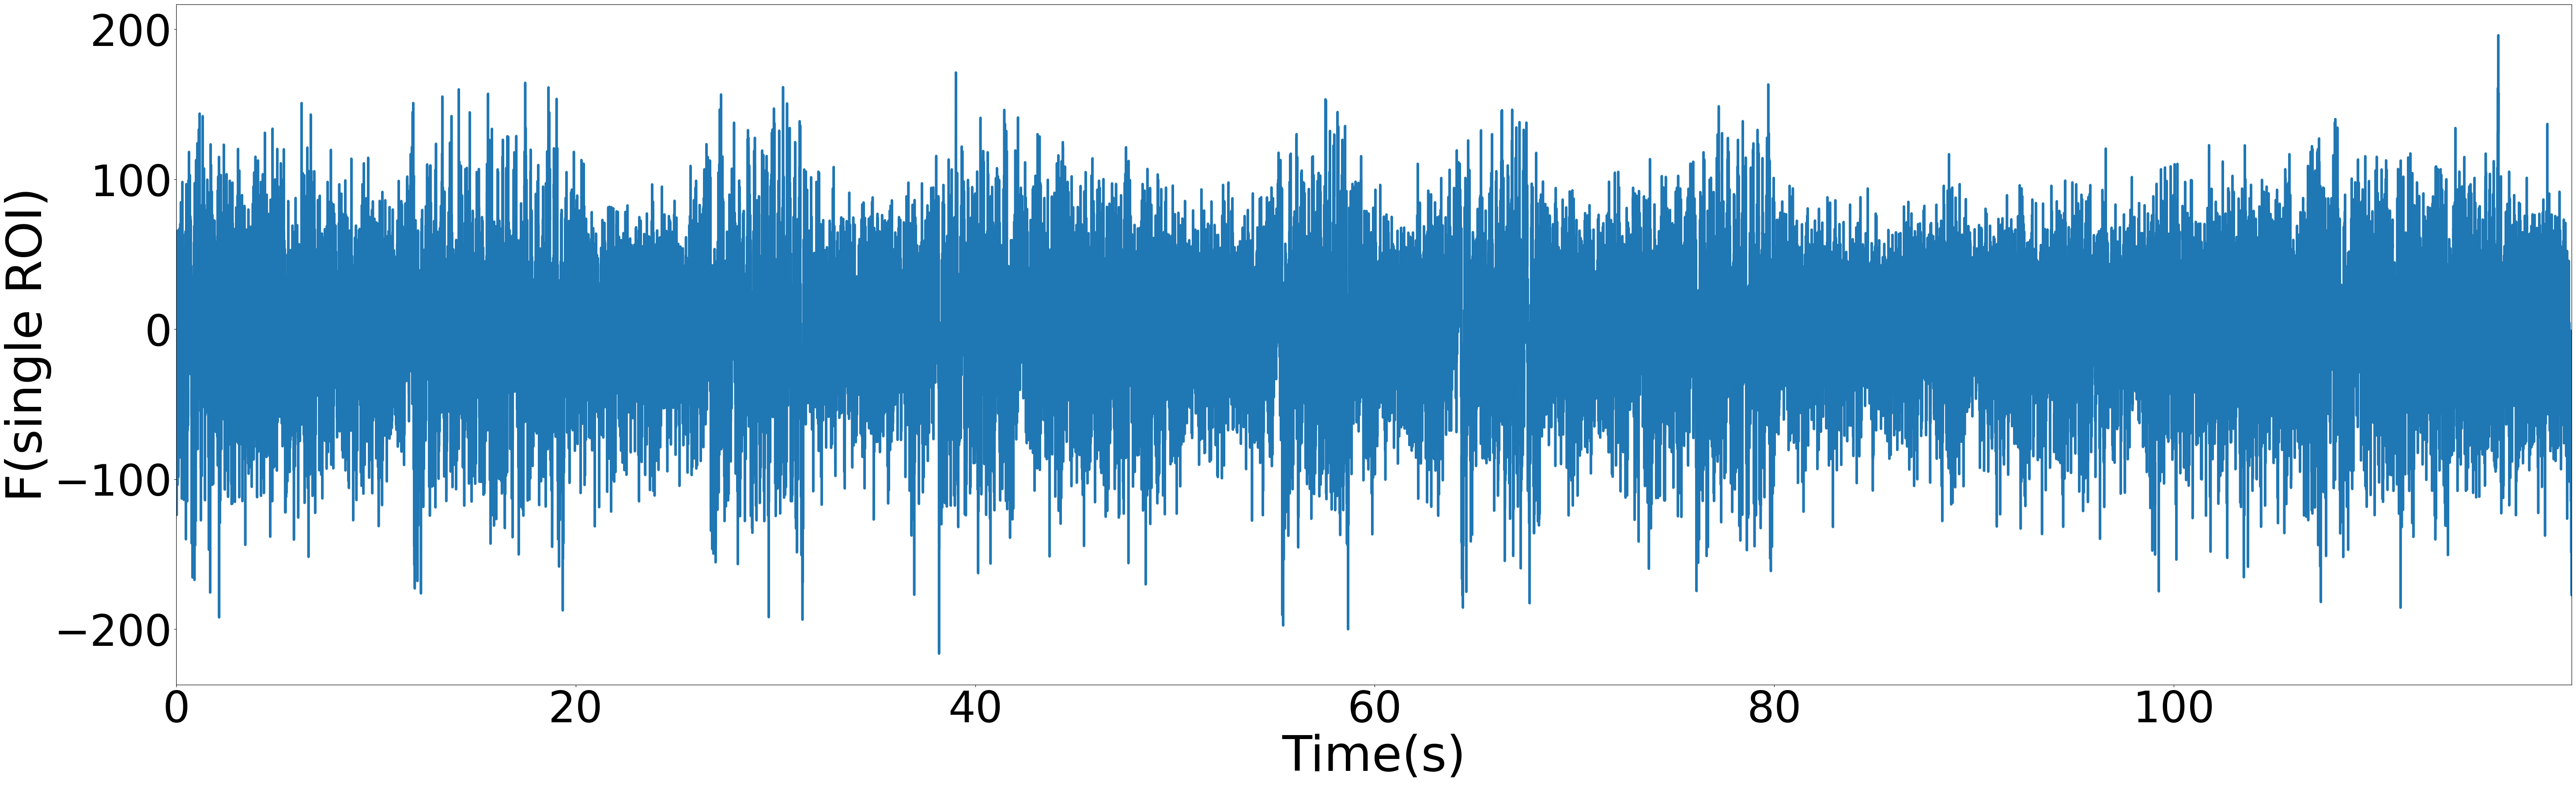

In [117]:
F_array_red_hp = high_pass_filter_TQ(F_array_red,1,volume_rate)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,-F_array_hp,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('F(single ROI)', fontsize=80)
plt.show()

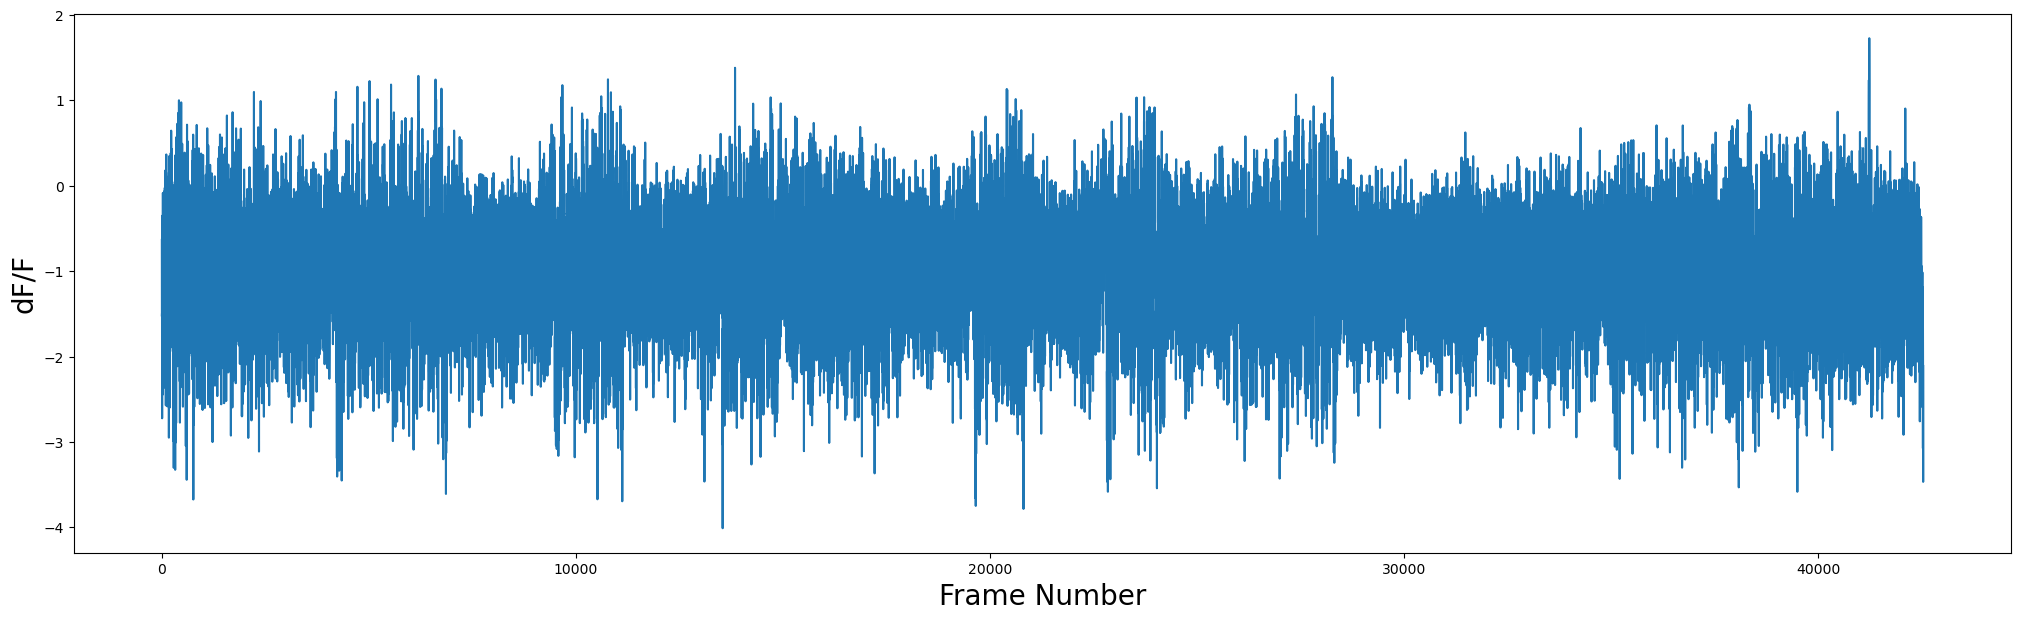

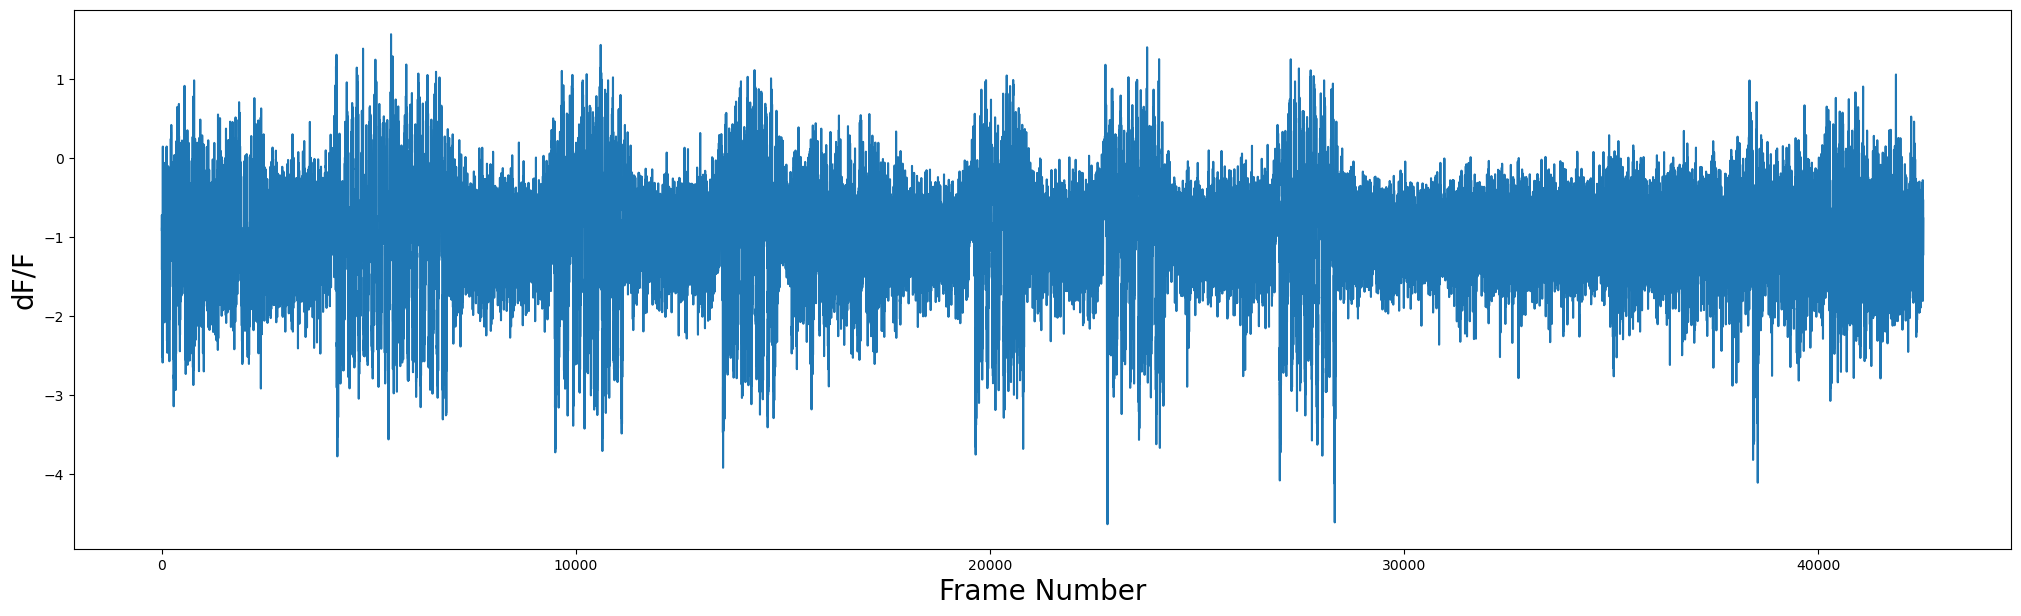

In [118]:
dF_F_array_HP = get_dff_array(raw_F_array = F_array_hp, ROI_num = ROI_total, F_zero_cutoff = 0.05)
if red == 1:
    dF_F_array_red_HP = get_dff_array(raw_F_array = F_array_red_hp, ROI_num = ROI_total, F_zero_cutoff = 0.05)

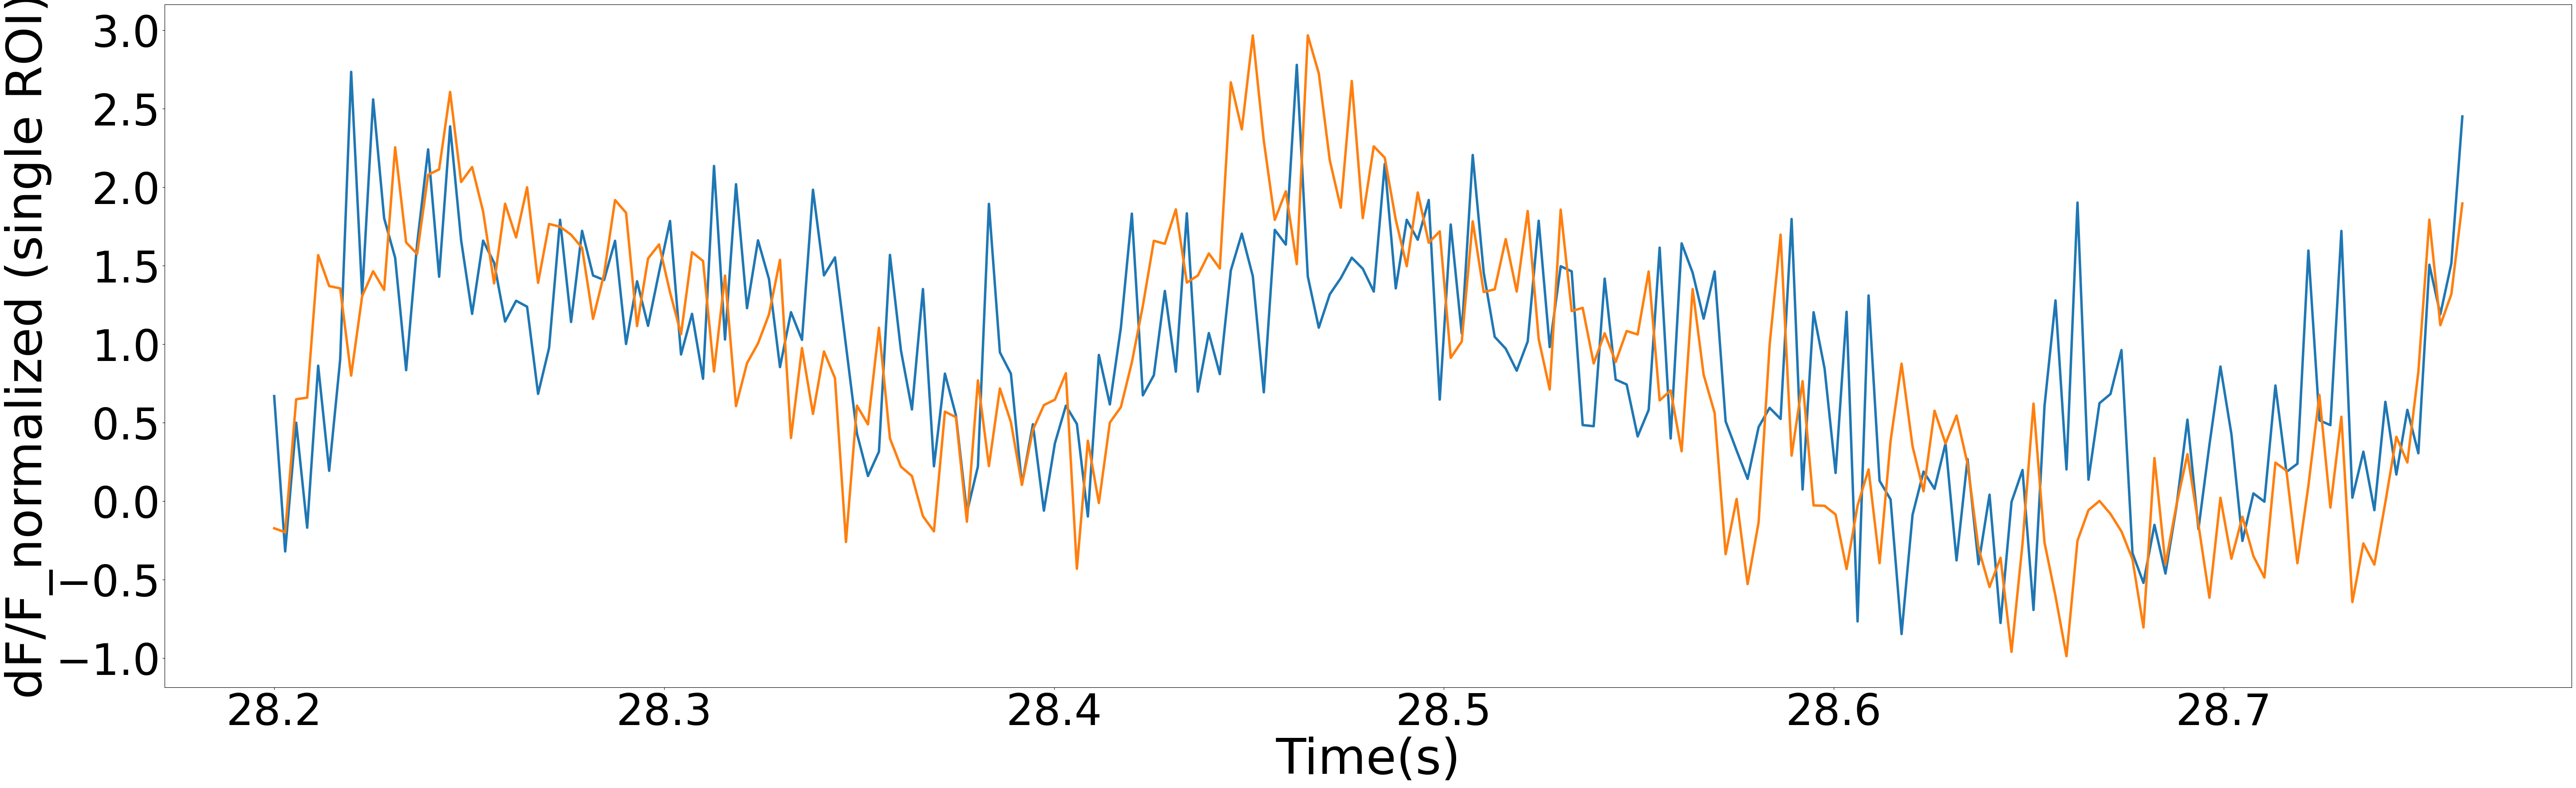

In [124]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging[10000:10200],-dF_F_array_HP[10000:10200],linewidth =4)
plt.plot(time_array_imaging[10000:10200],-dF_F_array_red_HP[10000:10200],linewidth =4)
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('dF/F_normalized (single ROI)', fontsize=80)
plt.show()